In [16]:
library(MASS)
library(ggplot2)
library(cowplot)

options(repr.plot.width=17, repr.plot.height=8)

### Kernel
k <- function(x,x2) exp(-(x-x2)^2)
# k <- function(x,x2) exp(-5*(x-x2)^2)

# Objective function noise
f <- function(x) sin(1.2*x) + sin((10.0 / 3) * x)
# f <- function(x) -exp(-x)*sin(2*pi*x)
f.noise <- 0

# Constant prior value
prior.mu <- 0

# Plot values
x.limits <- c(0, 10)
y.limits <- c(-3, 3)

# Optimization values
n.iterations <- 30
batch.size <- 3

options(repr.plot.width=17, repr.plot.height=8)

In [17]:
# Function definitions

calculate.regression.model <- function(X, y) {
  K <- outer(X, X, k)
  d <- dim(K)[1]
  if (d == 0) {
    Ki <- K
  } else if (d == 1) {
    Ki <- 1/(K + f.noise)
  } else {
    Ki <- ginv(K + f.noise*diag(K))
  }
  
  fs <- function(Xs) {
    Ks <- outer(Xs, X, k)
    return(prior.mu + Ks %*% Ki %*% (y - prior.mu))
  }
  
  sigma <- function(Xs) {
    Ks <- outer(Xs, X, k)
    Kss <- outer(Xs, Xs, k)
    S <- Kss - Ks %*% Ki %*% t(Ks)
    if (Xs %in% observed.x)
      S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  if (d== 0) {
    best.x <- prior.mu
    best.y <- -1e10
  } else {
    best.x <- X[which.max(y)]
    best.y <- max(y)
  }
  
  return(list(mean=fs, cov=sigma, best.x=best.x, best.y=best.y))
}

choose.next.evaluation.points <- function(x, y.acq, observed.x, gp.model) {
  y2 <- y.acq[!x %in% observed.x]
  x2 <- x[!x %in% observed.x]
  order.index <- order(y2, decreasing = T)
  y2 <- y2[order.index]
  x2 <- x2[order.index]
  n.best <- sum(y2==y2[1])
  if (n.best == 1) {
    best.x <- 1
  } else {best.x <- sample(1:n.best, 1)}
  permutation <- c(best.x,sample(2:length(x2)))
  x2 <- x2[permutation]
  y2 <- y2[permutation]
  next.evaluation.points <- x2[1:batch.size]
  return(next.evaluation.points)
}

acq.func <- function(gp.model, x) {
  return(acq.func.ei(gp.model, x))
}

acq.func.ucb <- function(gp.model, x) {
  mu <- gp.model$mean(x)
  sigma <- sqrt(gp.model$cov(x)[1,1])
  lambda <- 1
  
  return(mu + lambda * sigma)
}

acq.func.pi <- function(gp.model, x) {
  mu <- gp.model$mean(x)
  sigma <- sqrt(gp.model$cov(x)[1,1])
  best.y <- gp.model$best.y
  
  return(pnorm((mu-best.y)/sigma))
}

acq.func.ei <- function(gp.model, x) {
  mu <- gp.model$mean(x)
  sigma <- sqrt(gp.model$cov(x)[1,1])
  best.y <- gp.model$best.y
  if (sigma > 0) {
    # return(max((mu-best.y)*pnorm((mu-best.y)/sigma) + sigma*dnorm((mu-best.y)/sigma), 0))
    return((mu-best.y)*pnorm((mu-best.y)/sigma) + sigma*dnorm((mu-best.y)/sigma))
  } else { # Observed value, no uncertainty
    return(max(mu-best.y,0))
  }
}

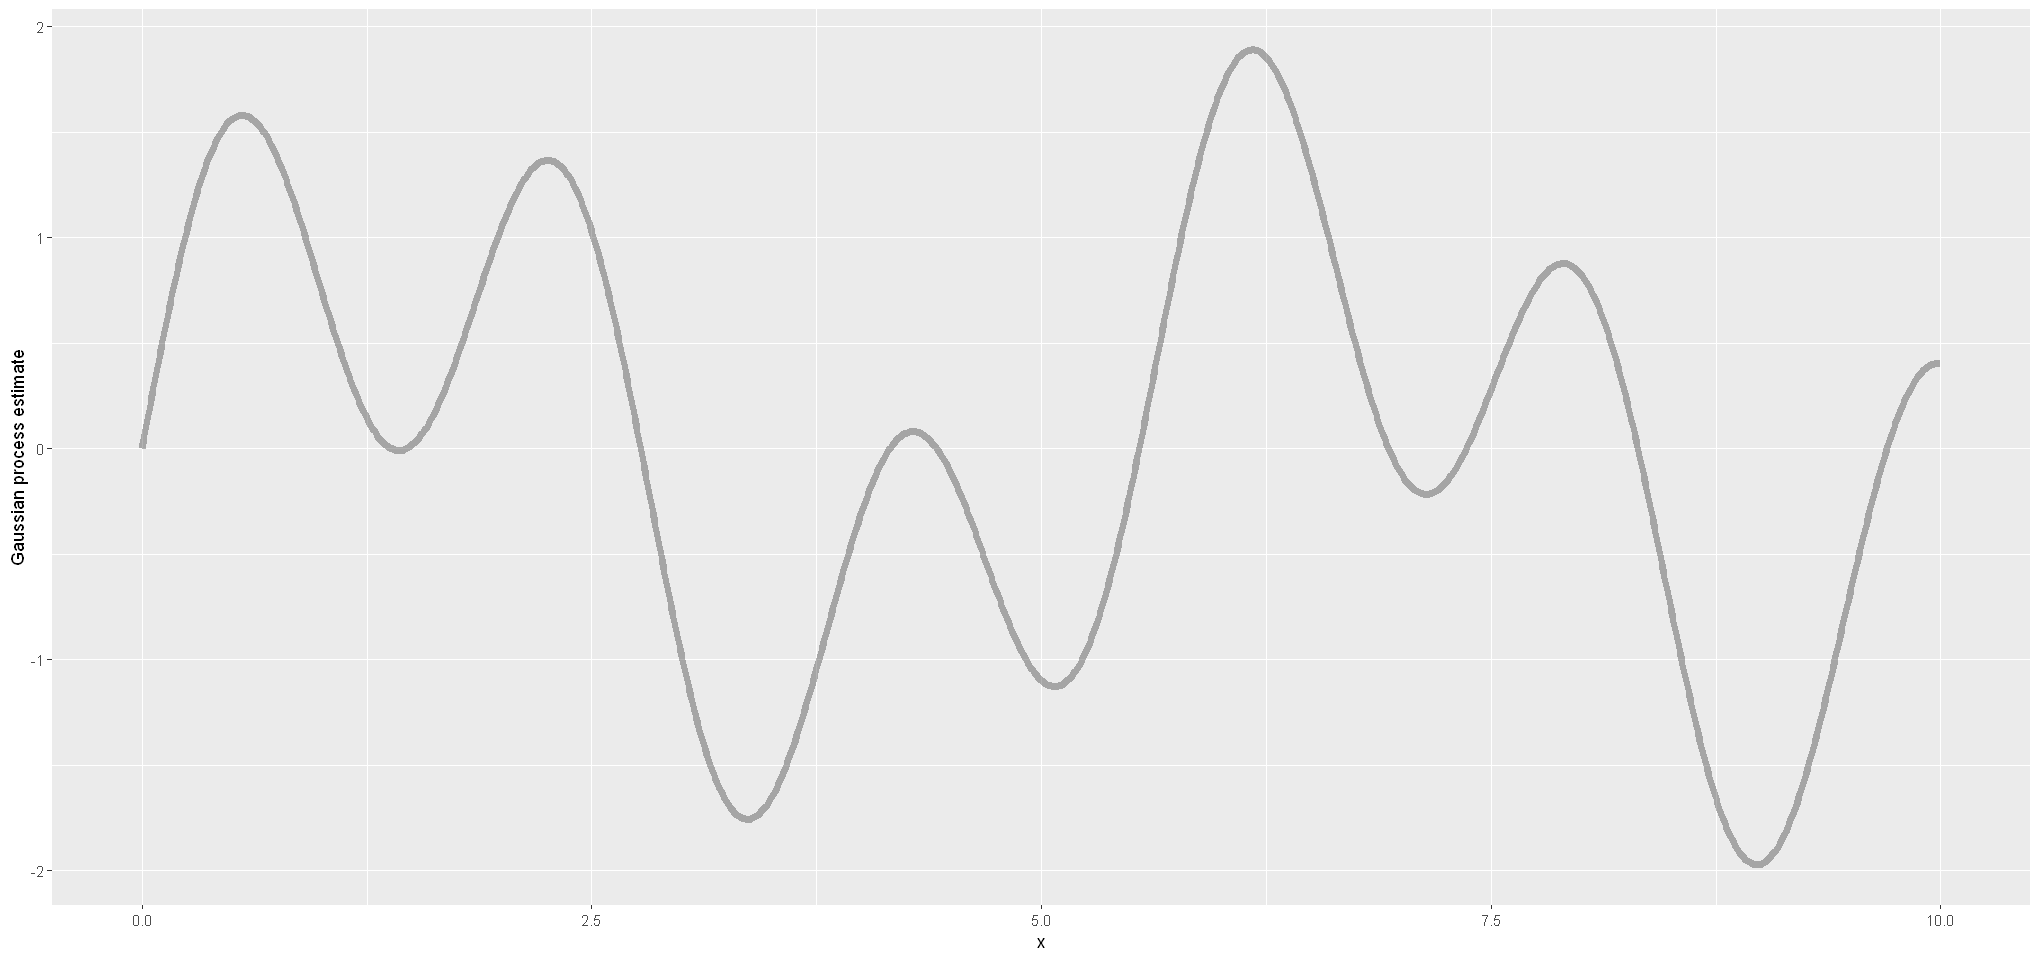

In [18]:
# Build target function plot

x.plt <- seq(0, 10, .01)
xx <- x.plt
yy <- f(xx)
df <- data.frame(x=xx, y=yy)

plt.f <- ggplot(df, aes(x=x, y=y)) + 
  geom_line(size=2, alpha=.3) +
  xlim(x.limits) +
  ylab('Gaussian process estimate')
plt.f

Iteration 1 


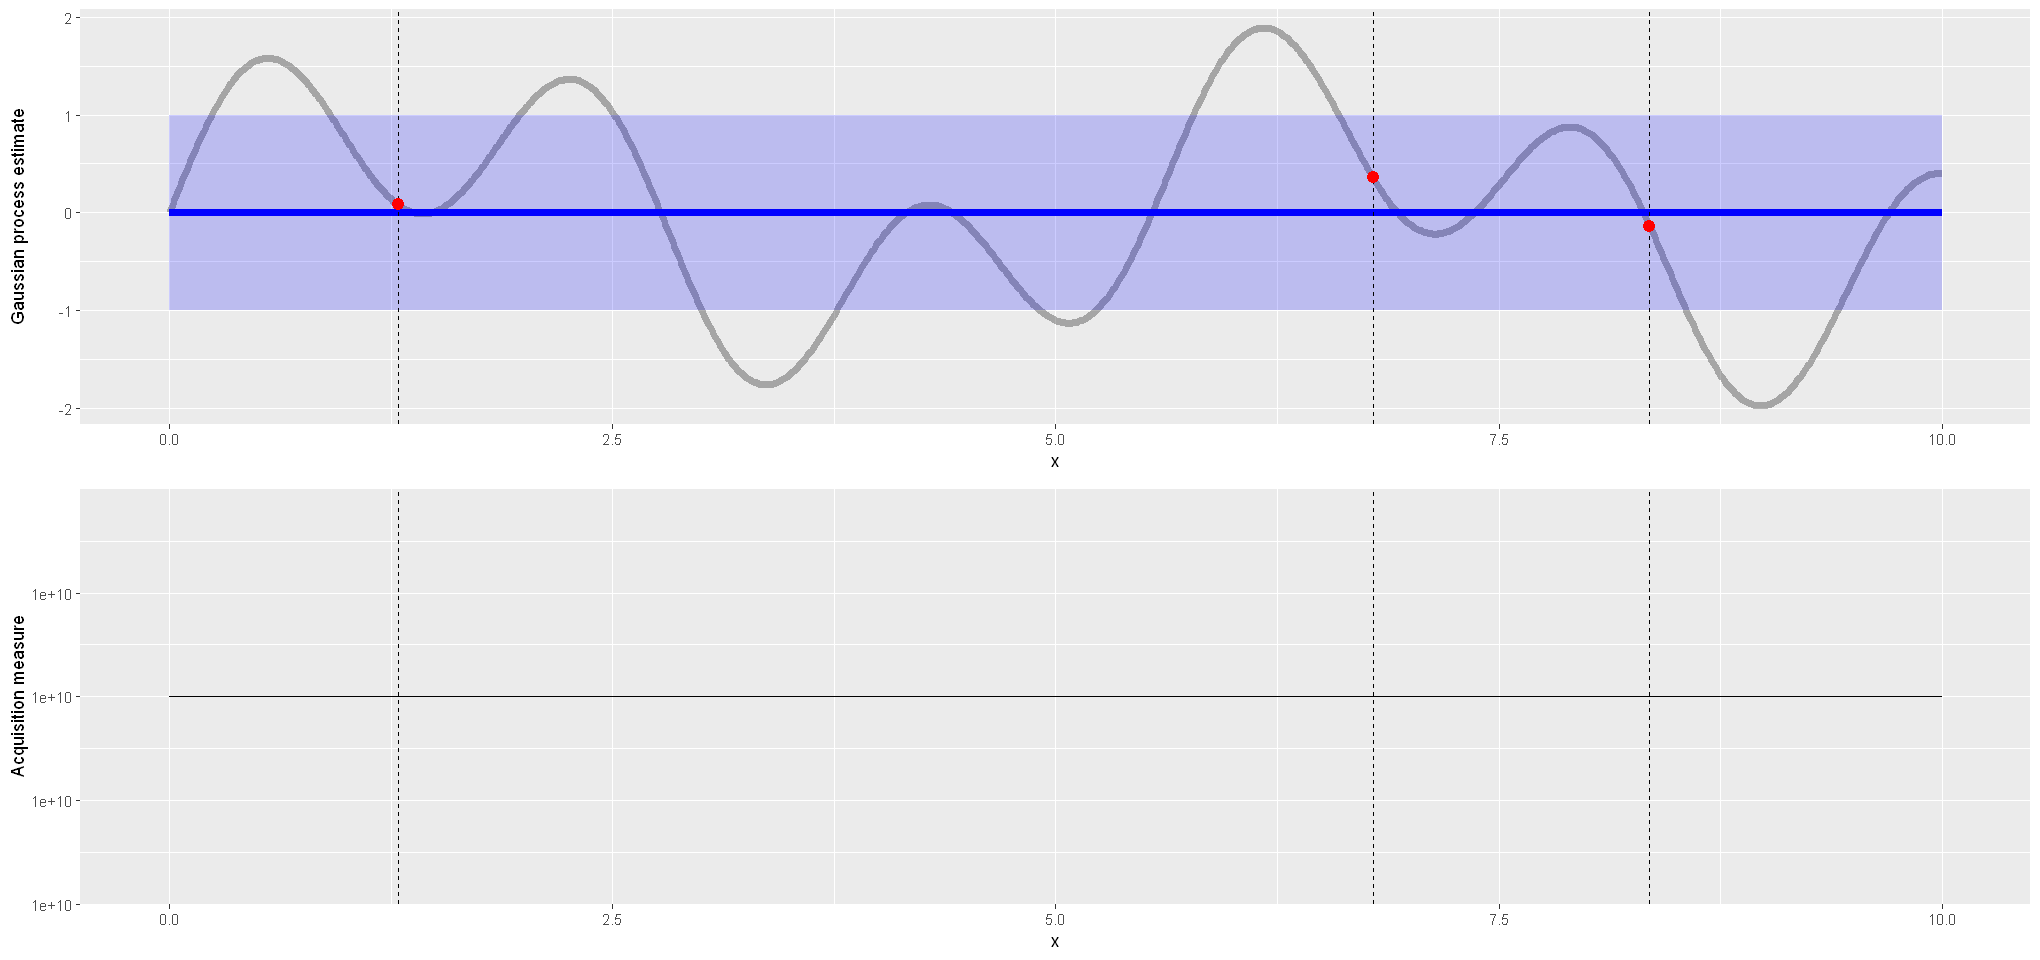

Iteration 2 


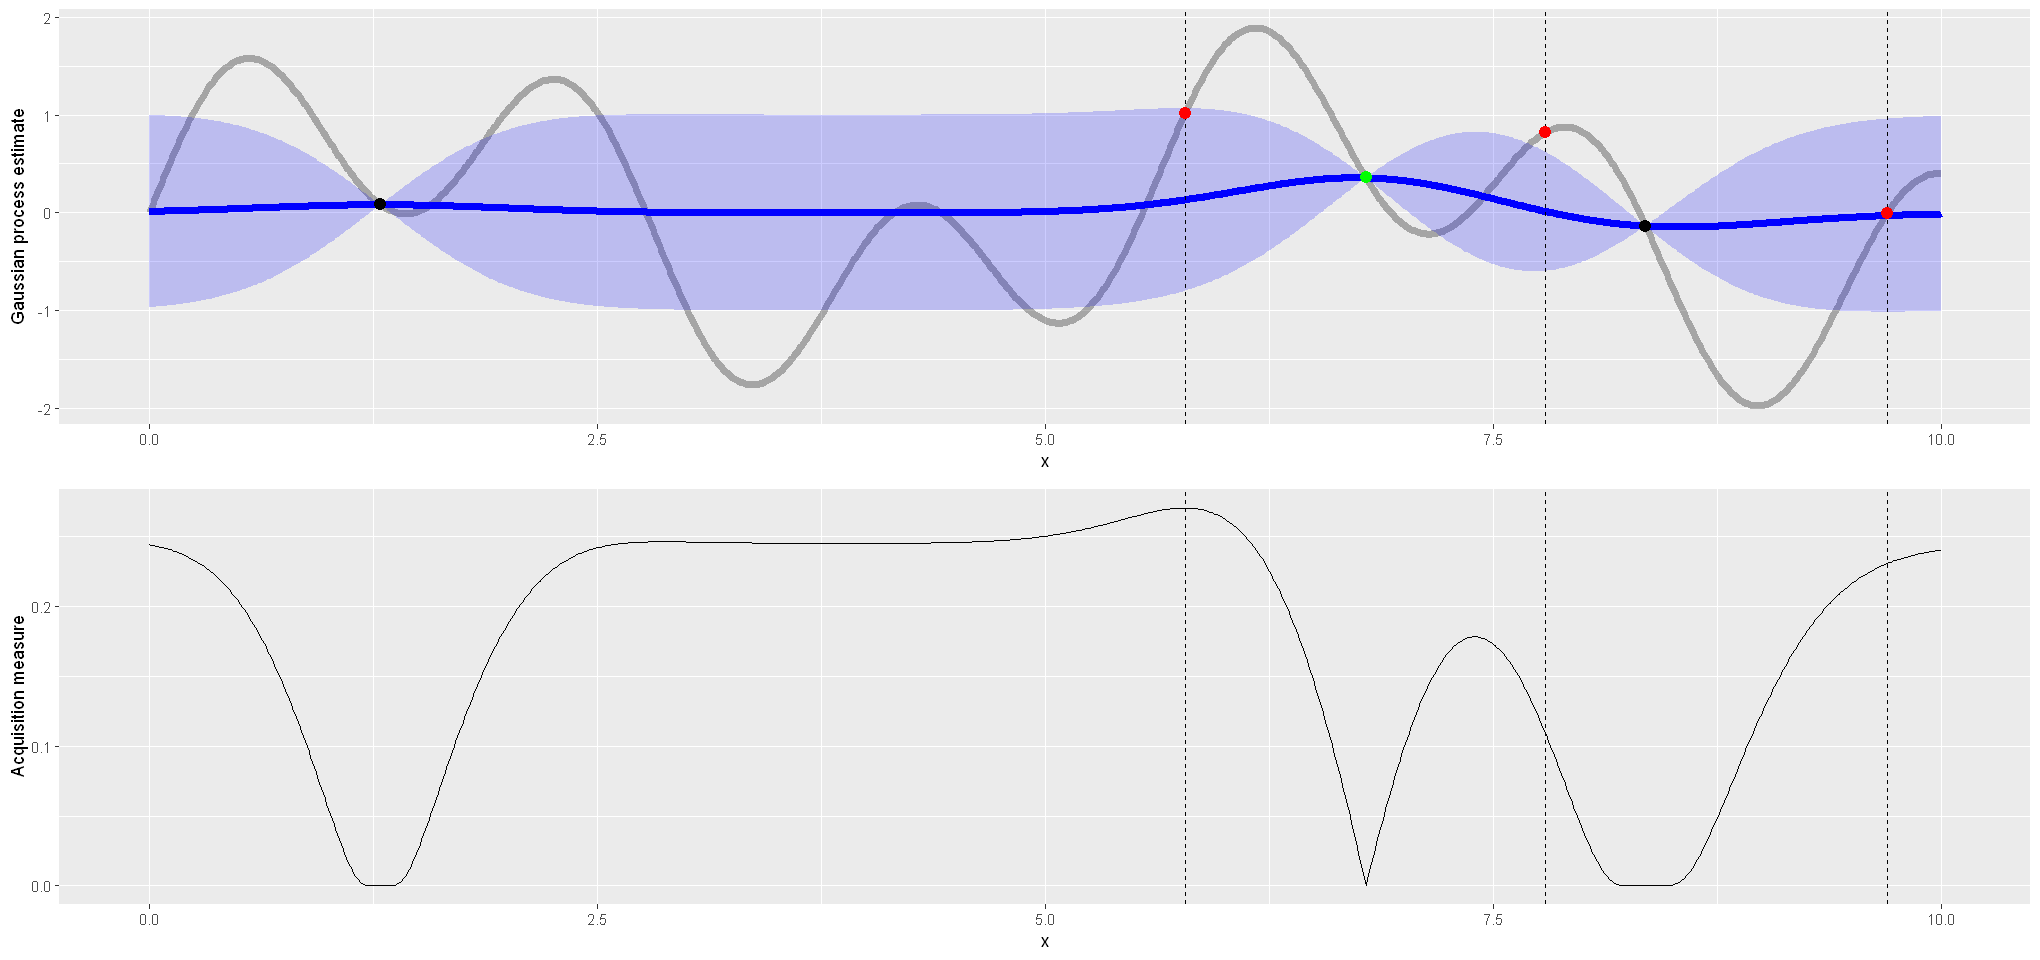

Iteration 3 


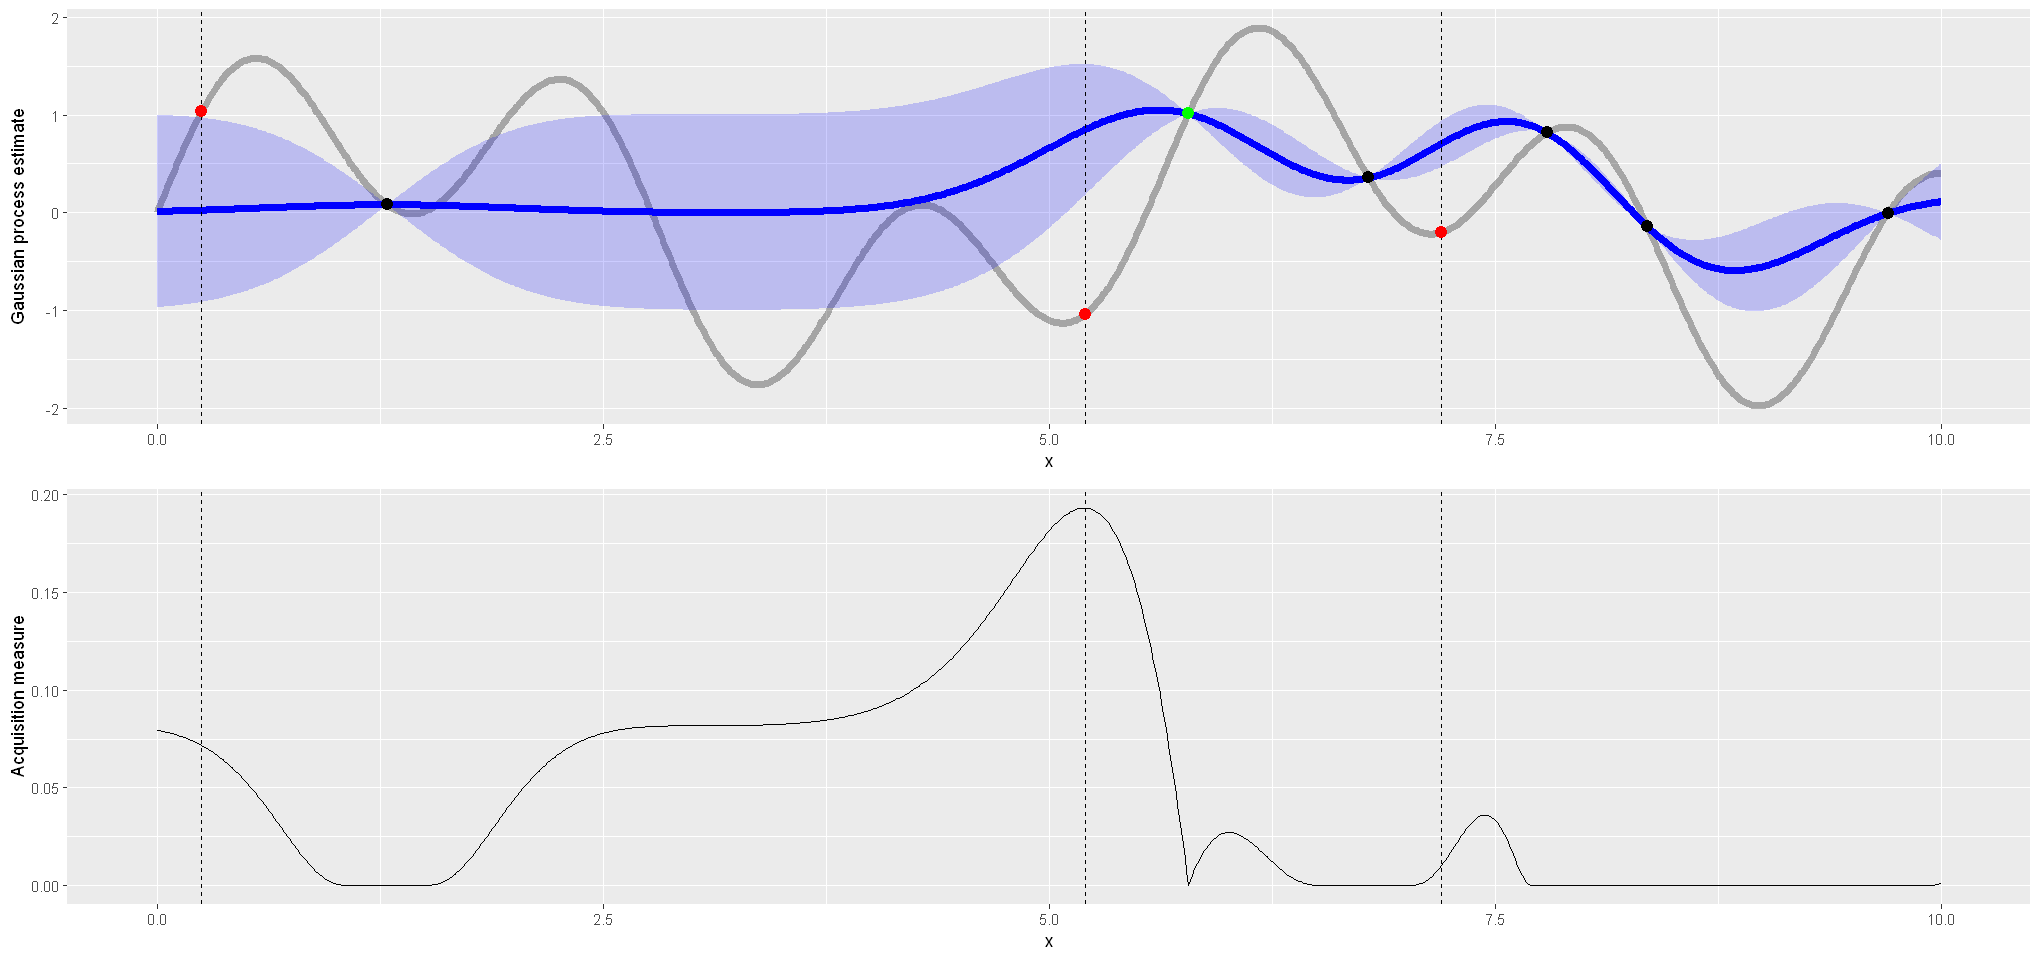

Iteration 4 


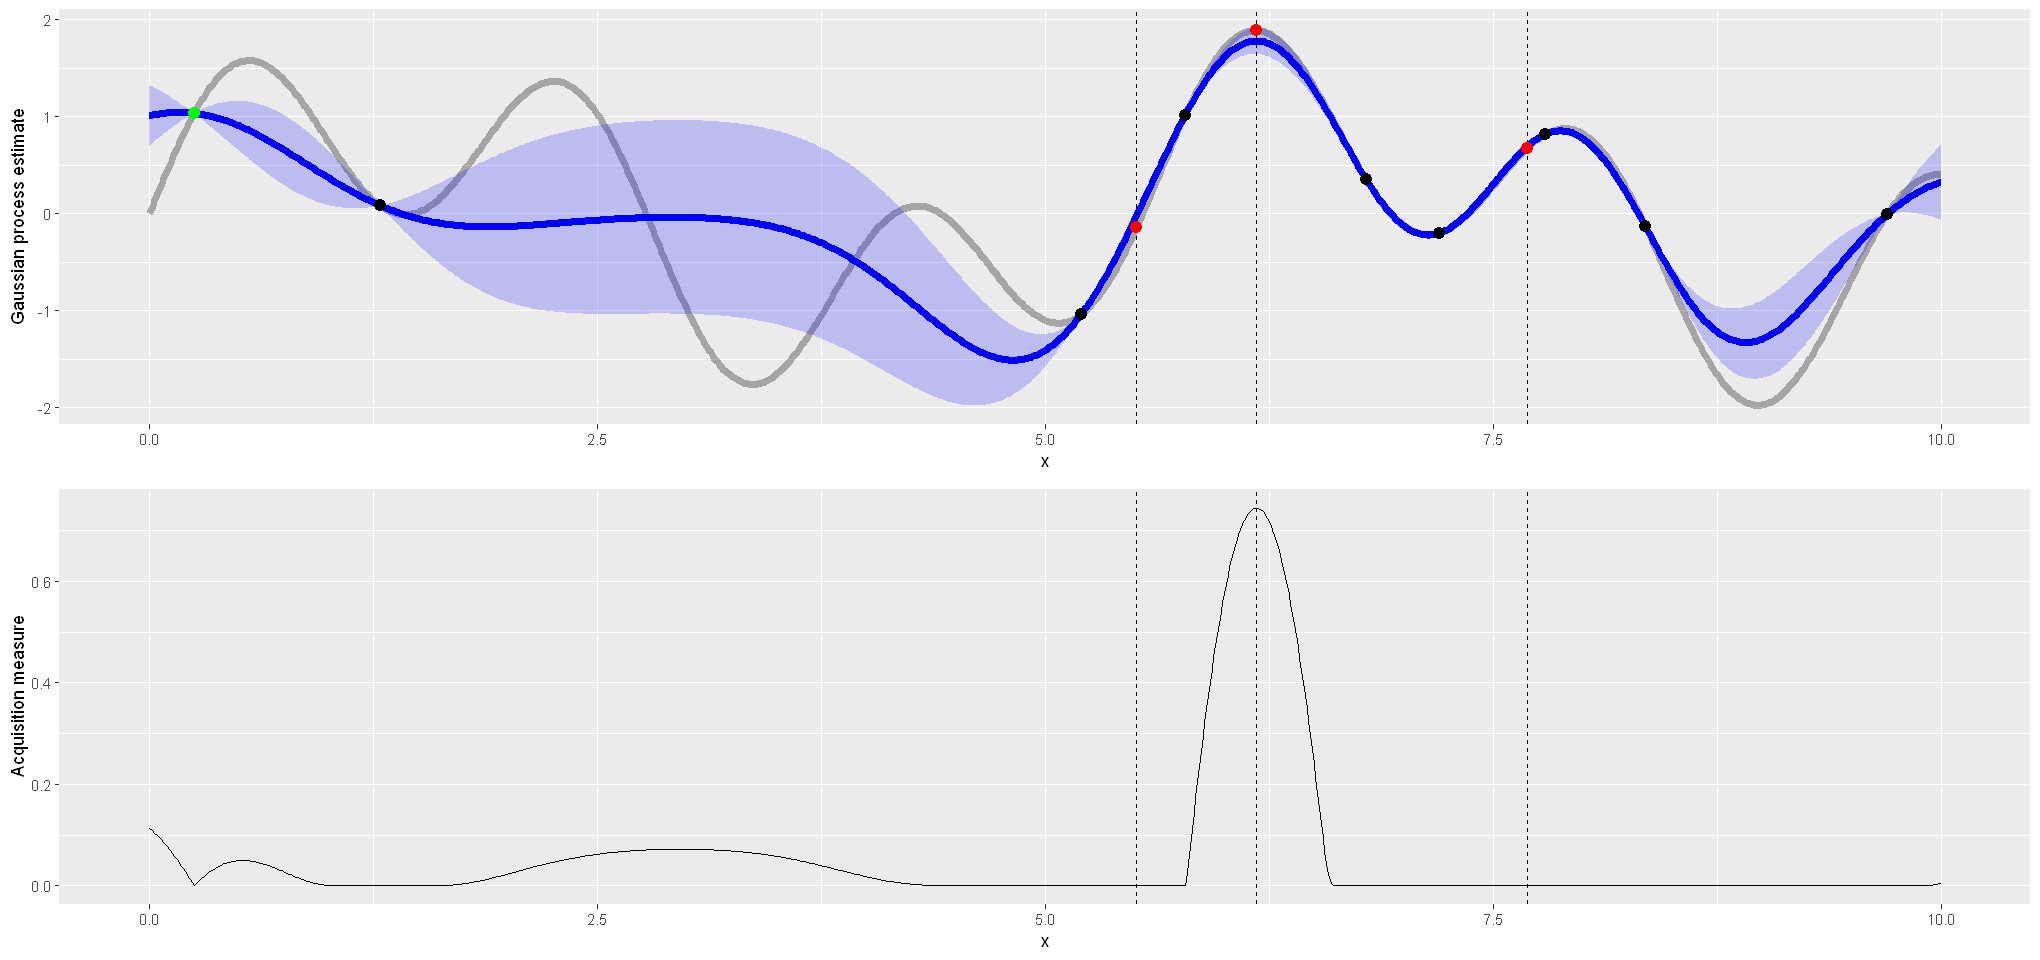

Iteration 5 


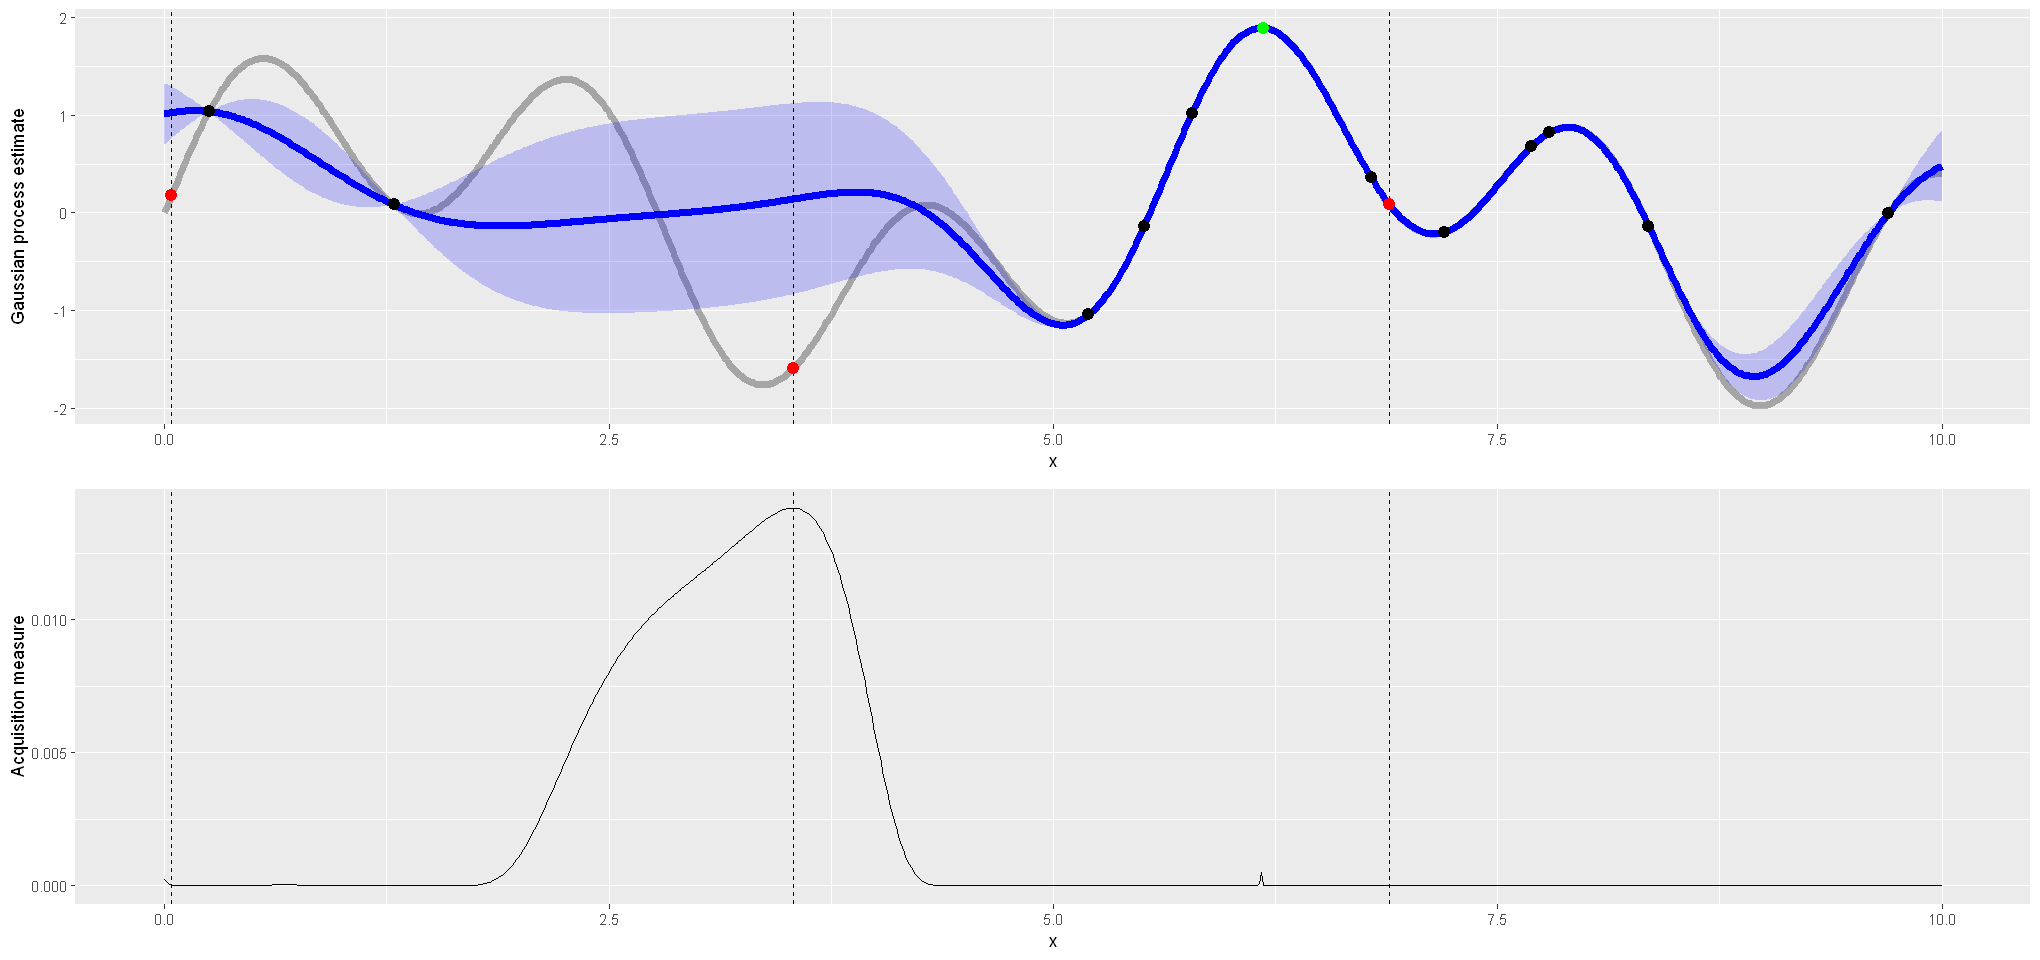

Iteration 6 


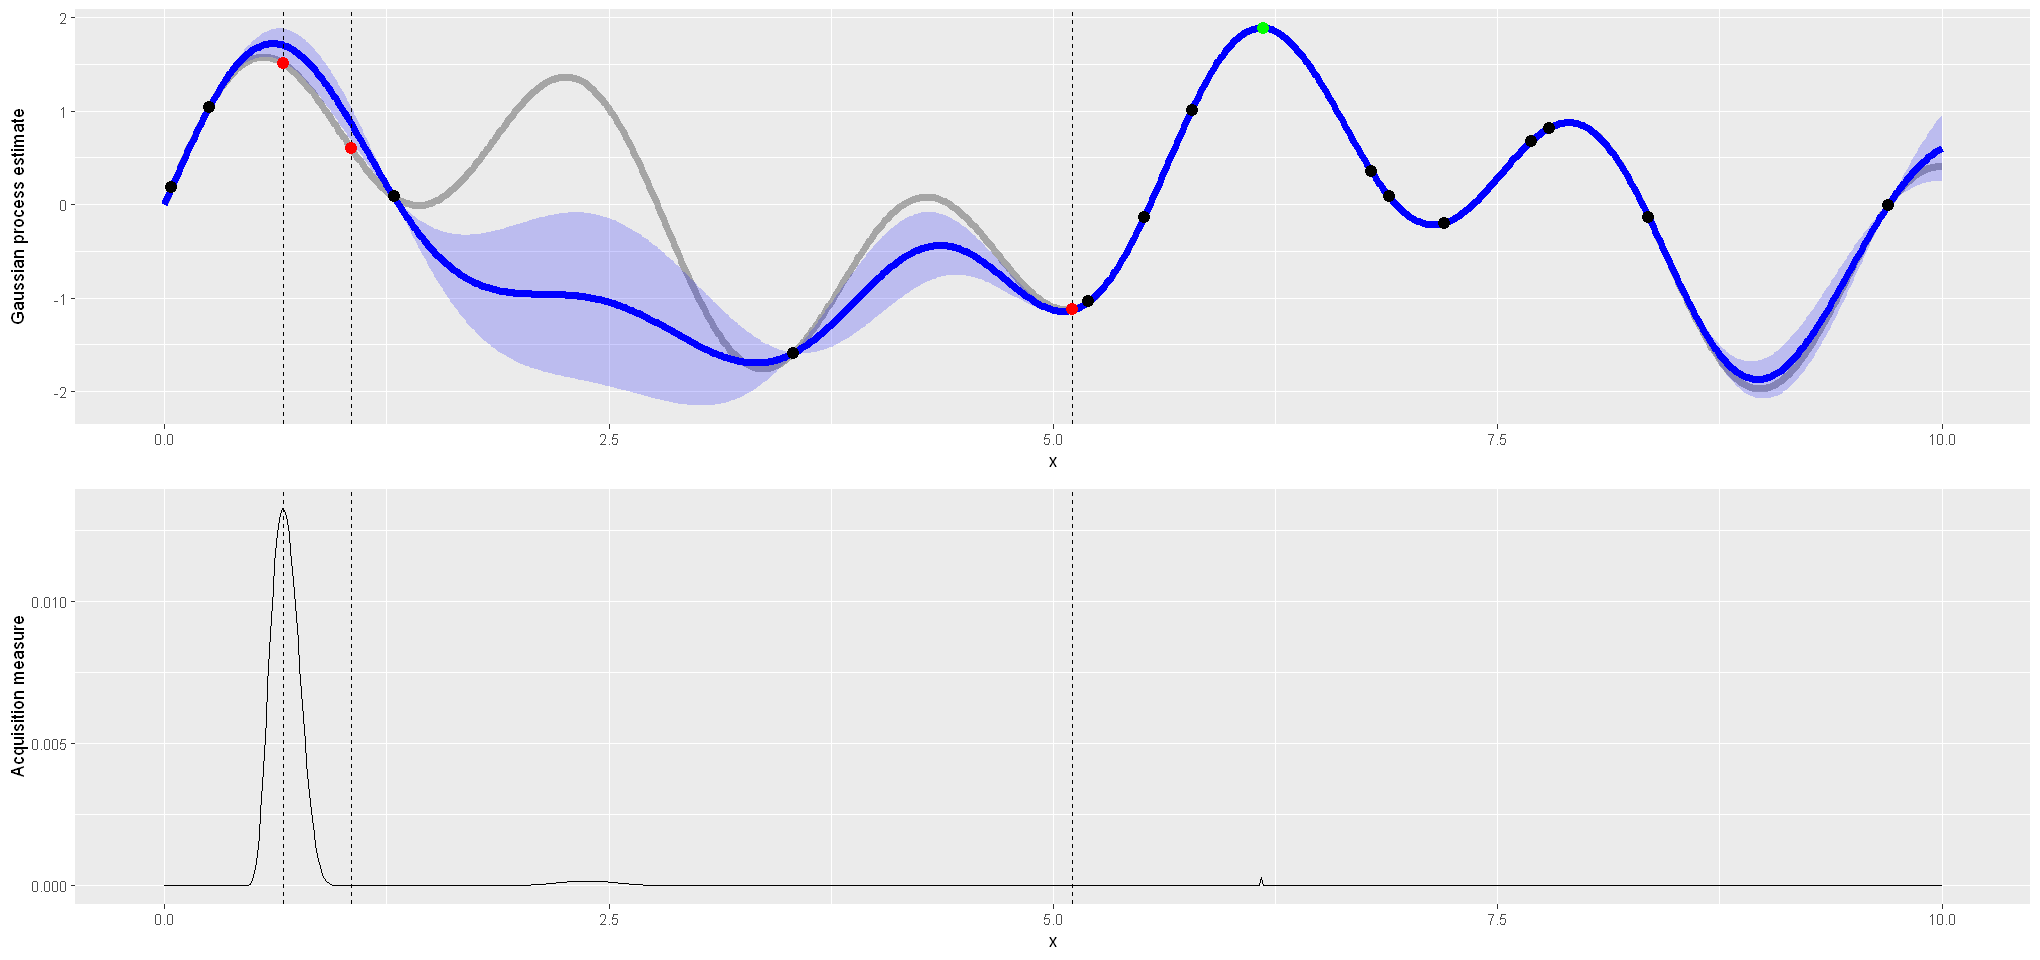

Iteration 7 


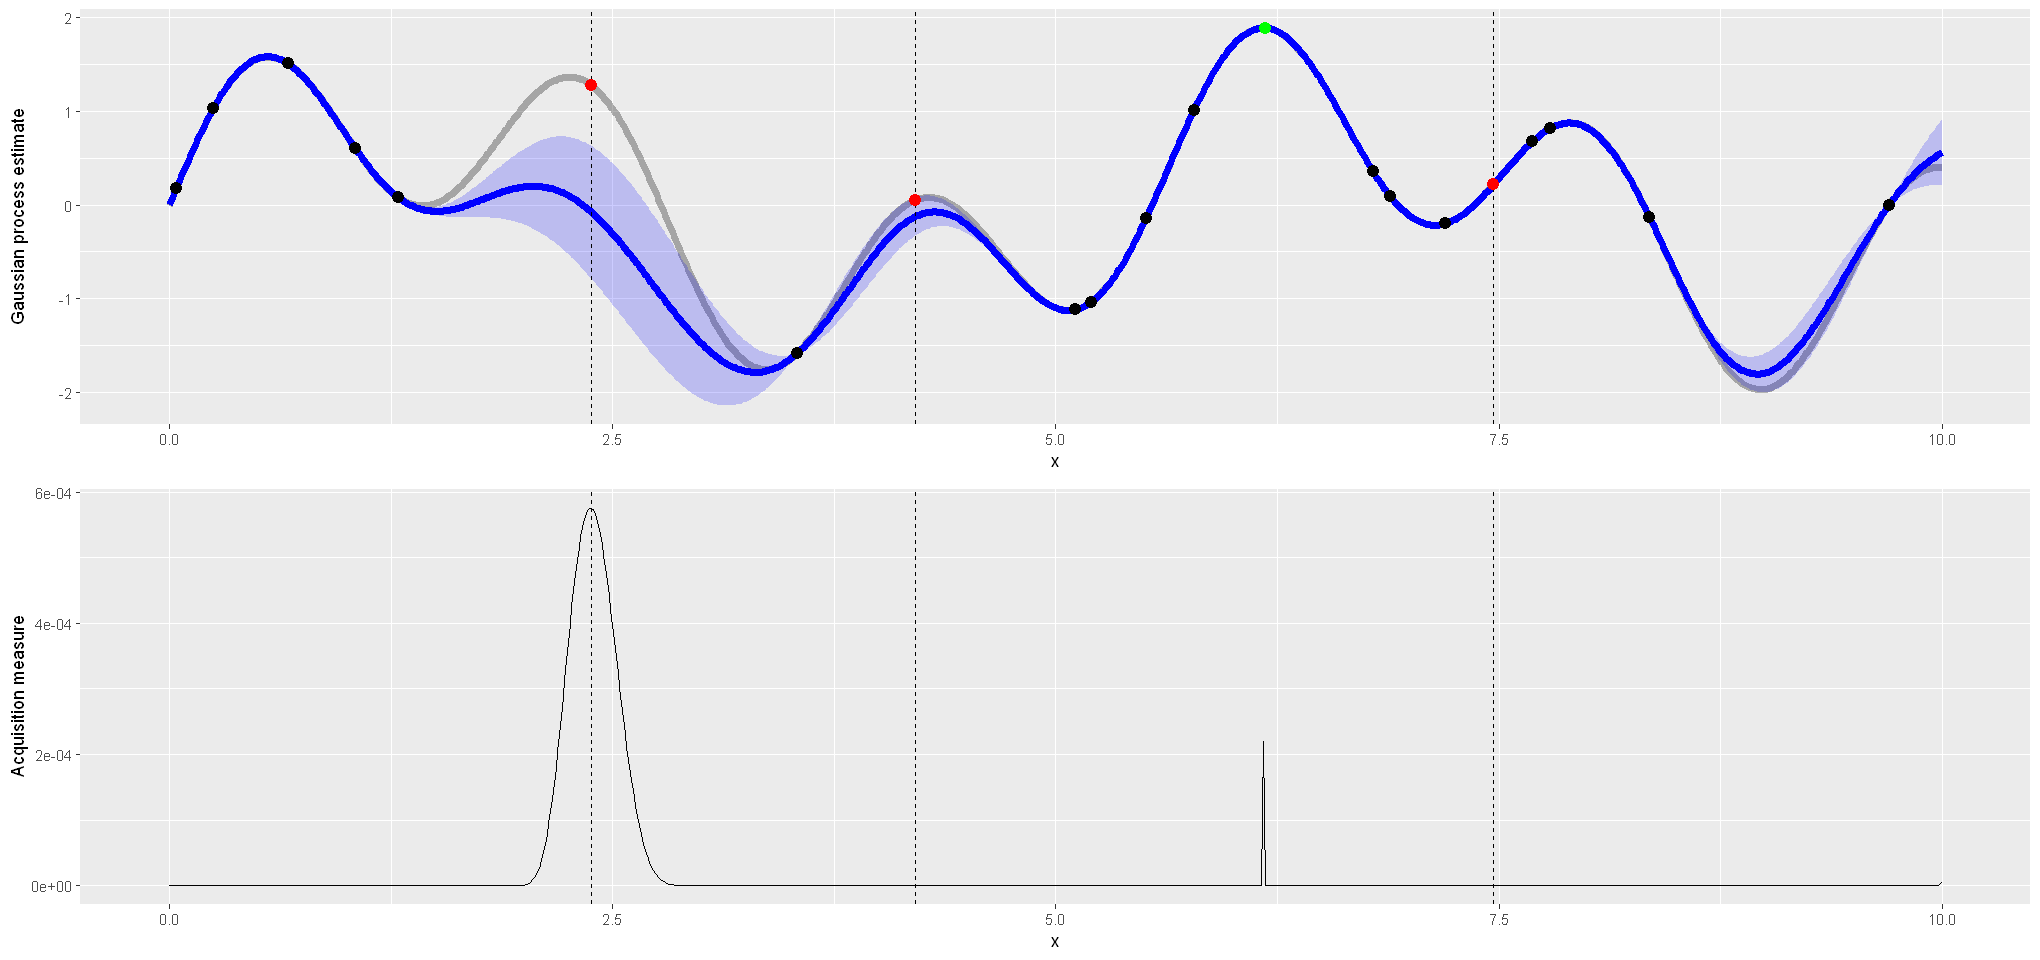

Iteration 8 


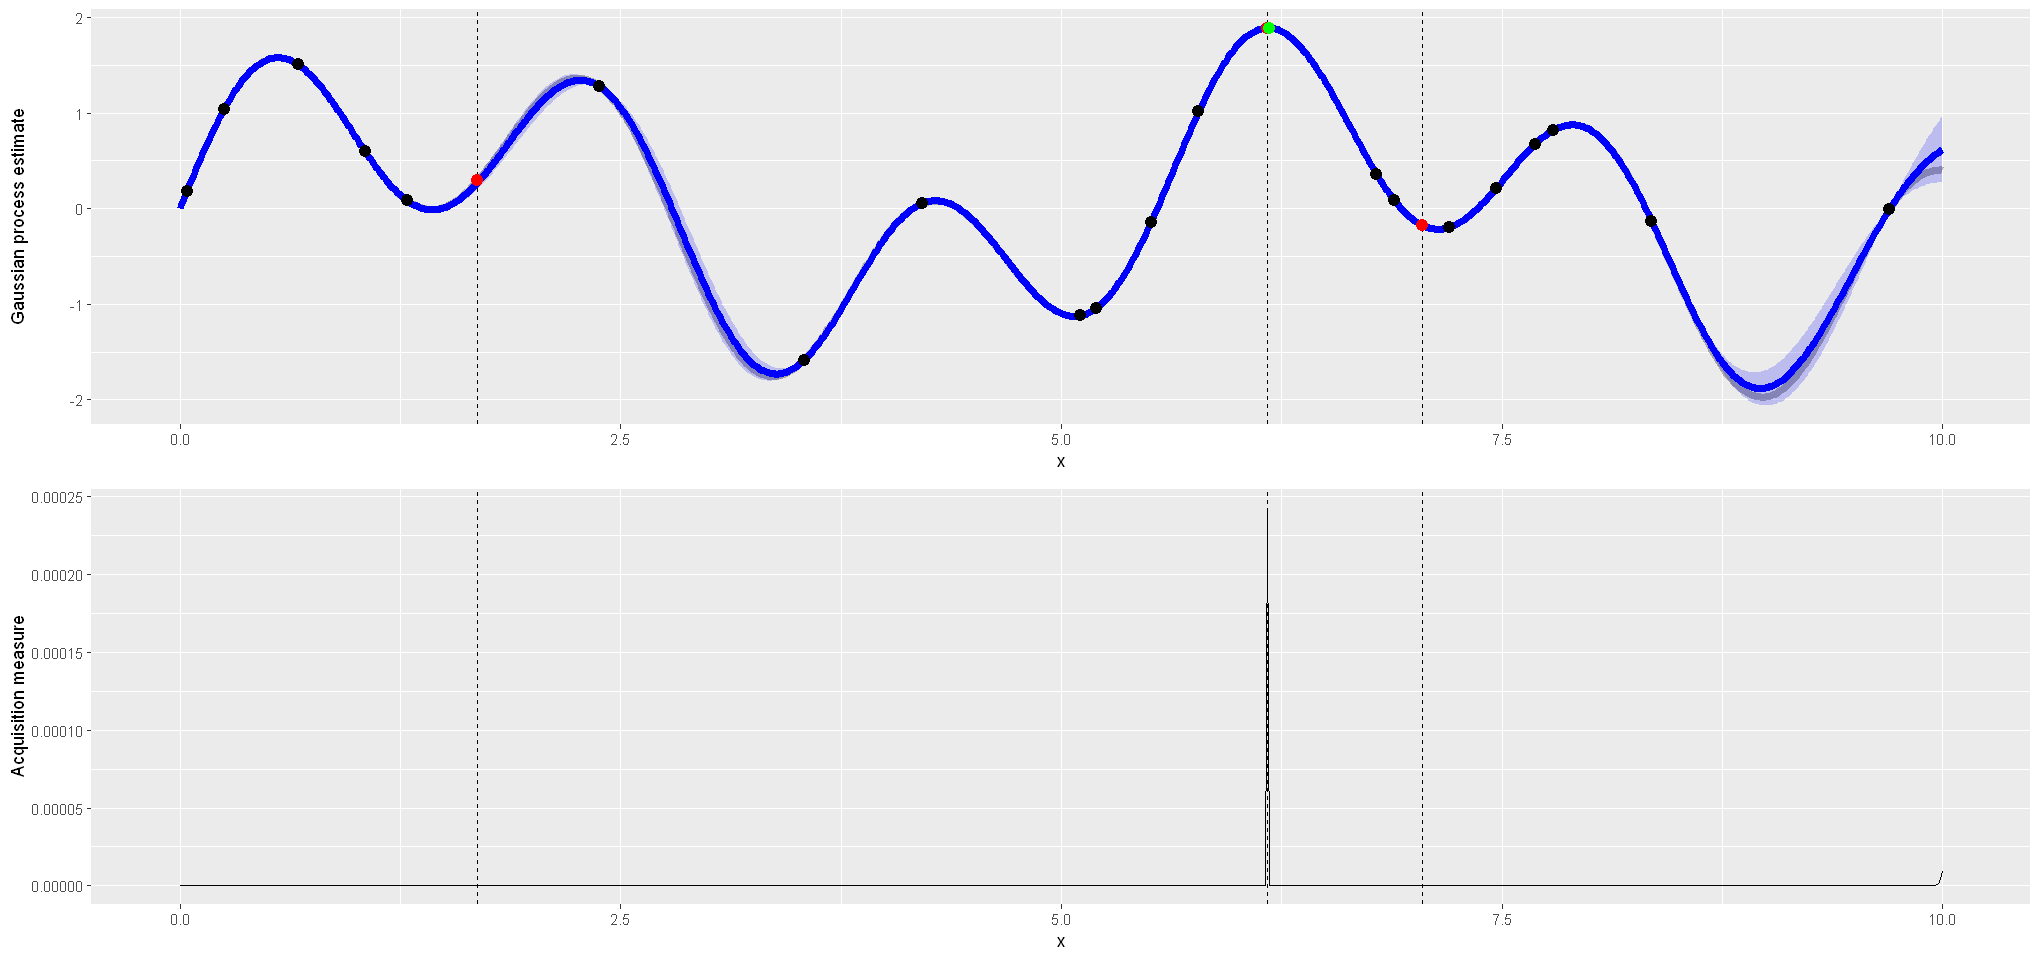

Iteration 9 


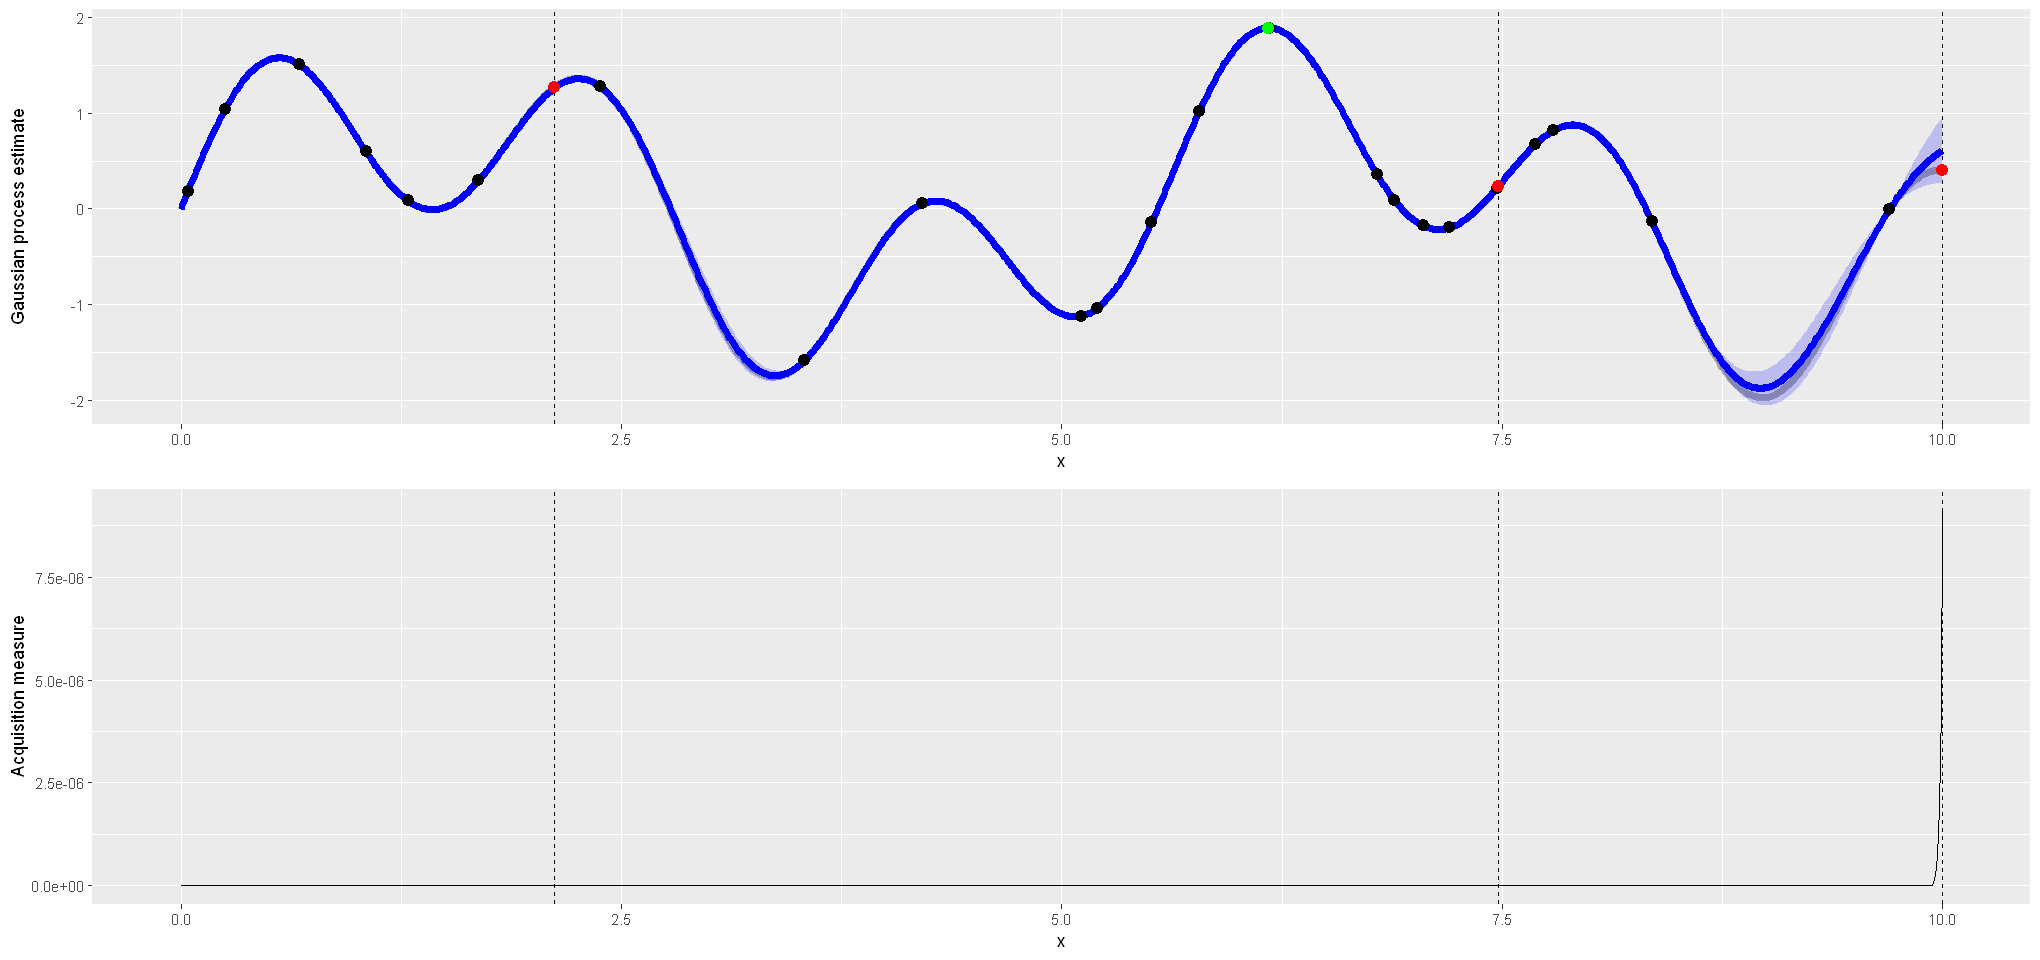

Iteration 10 


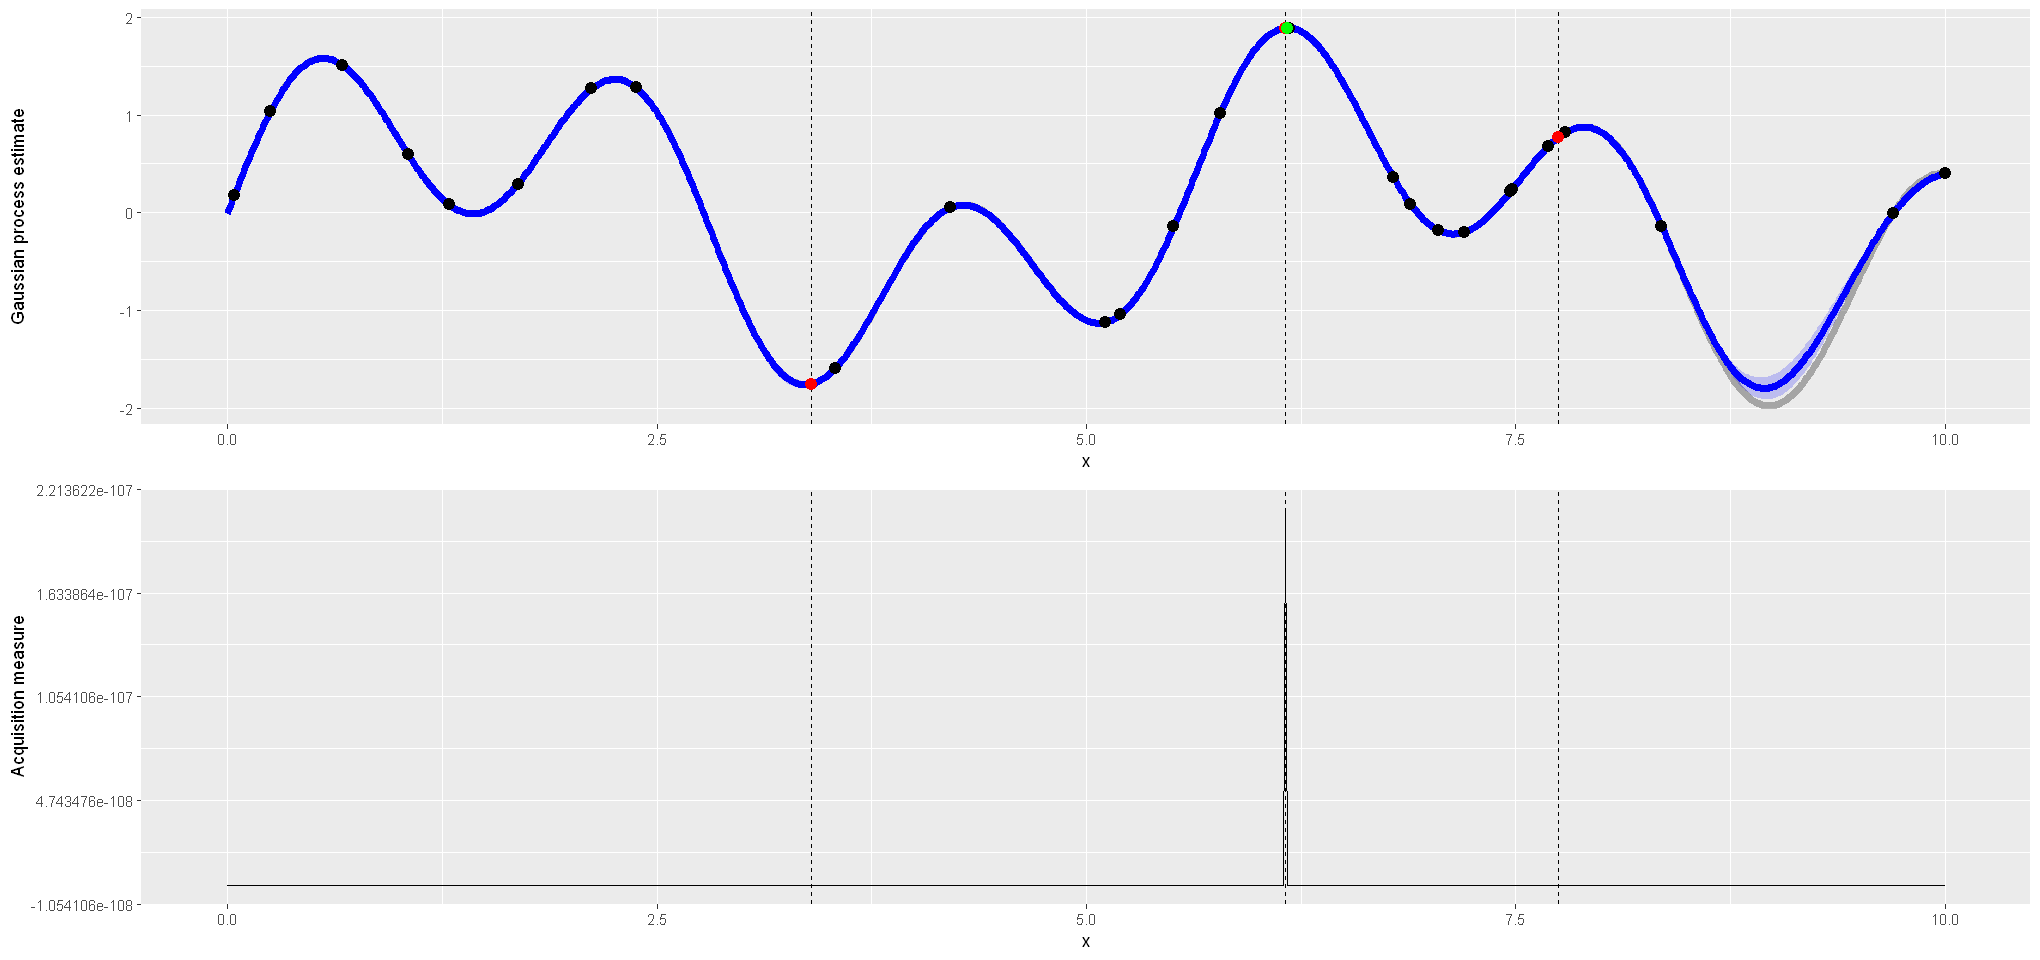

Iteration 11 


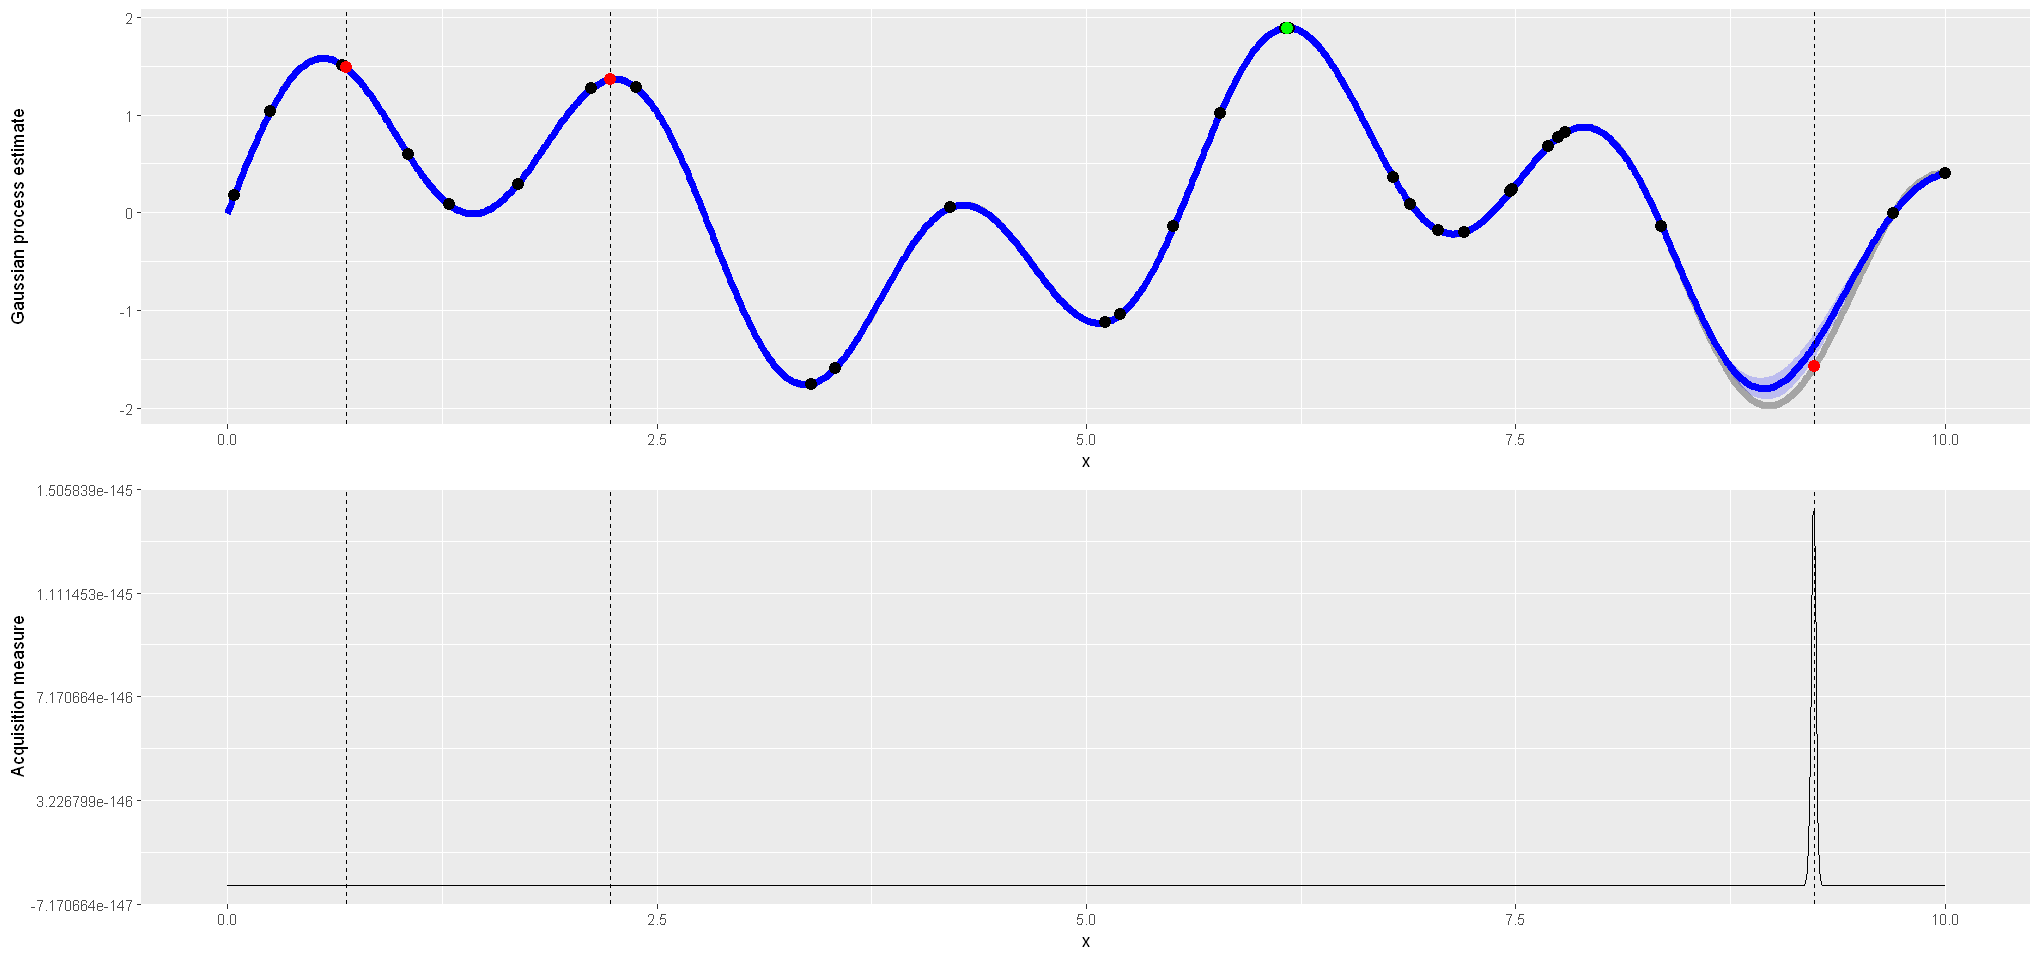

Iteration 12 


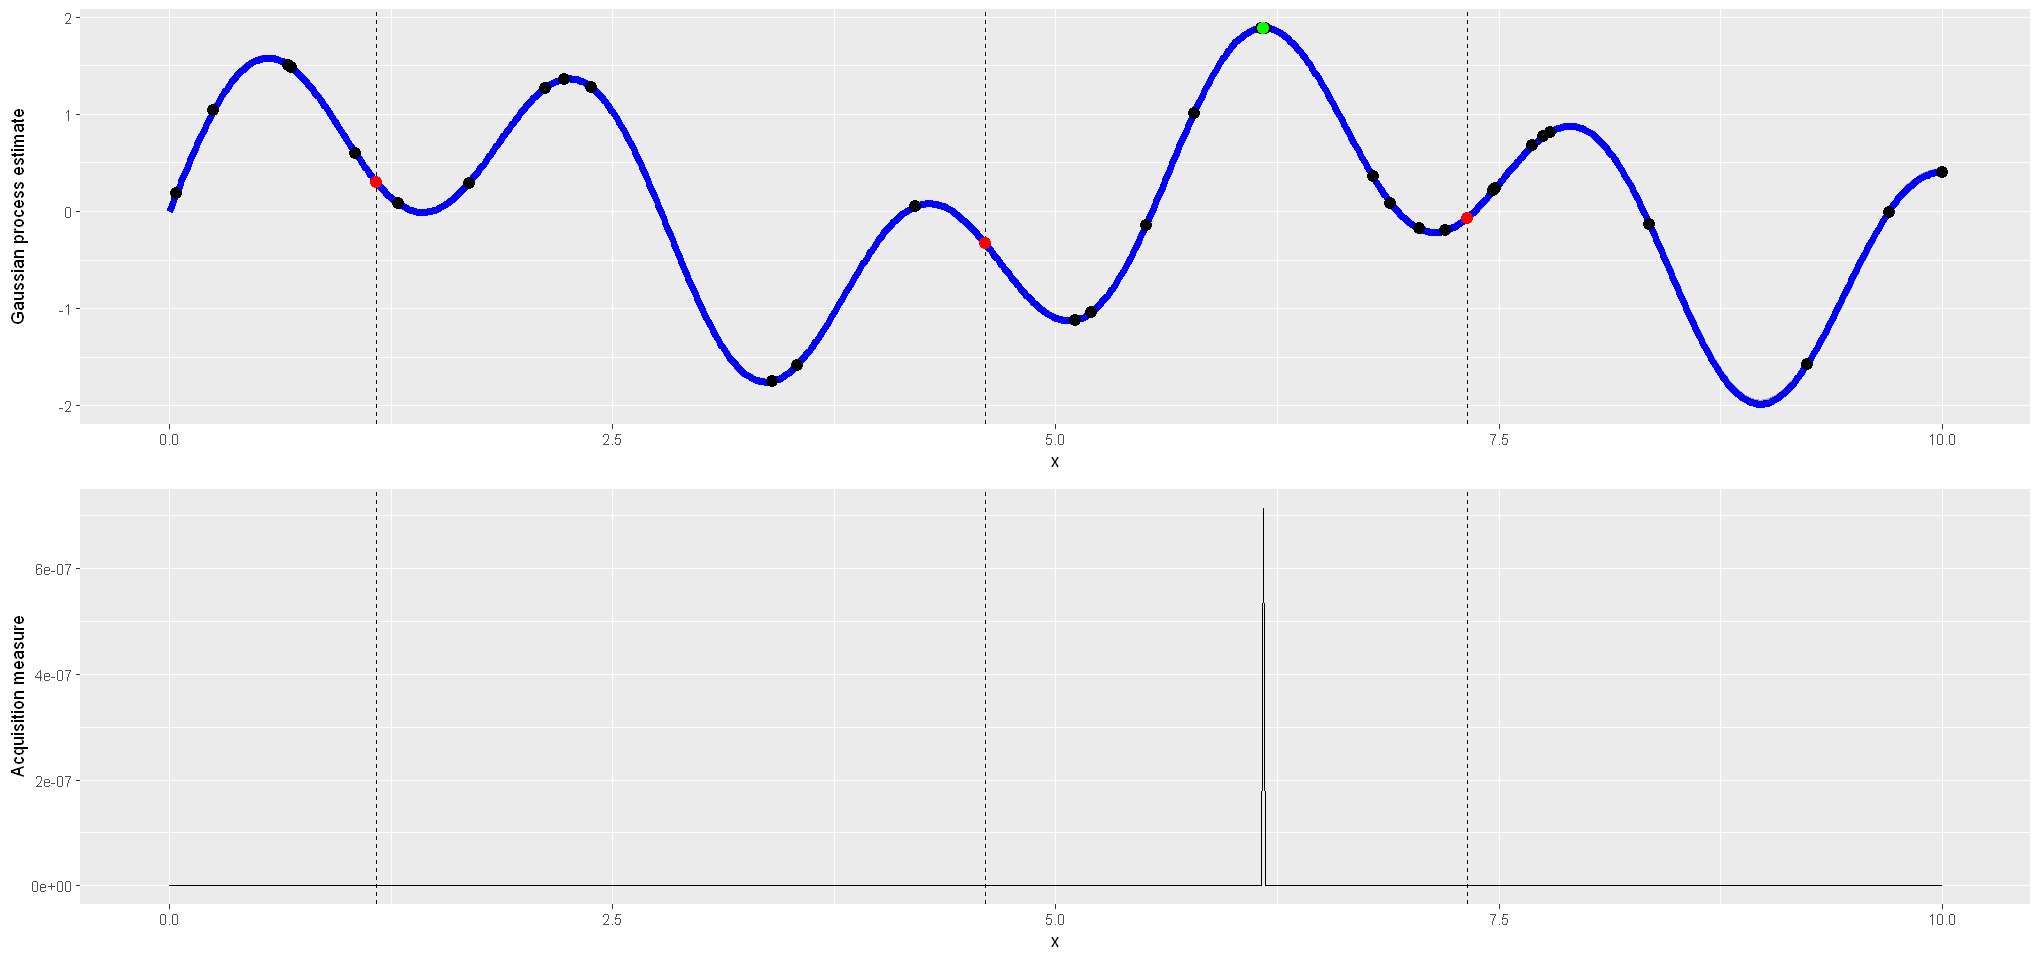

Iteration 13 


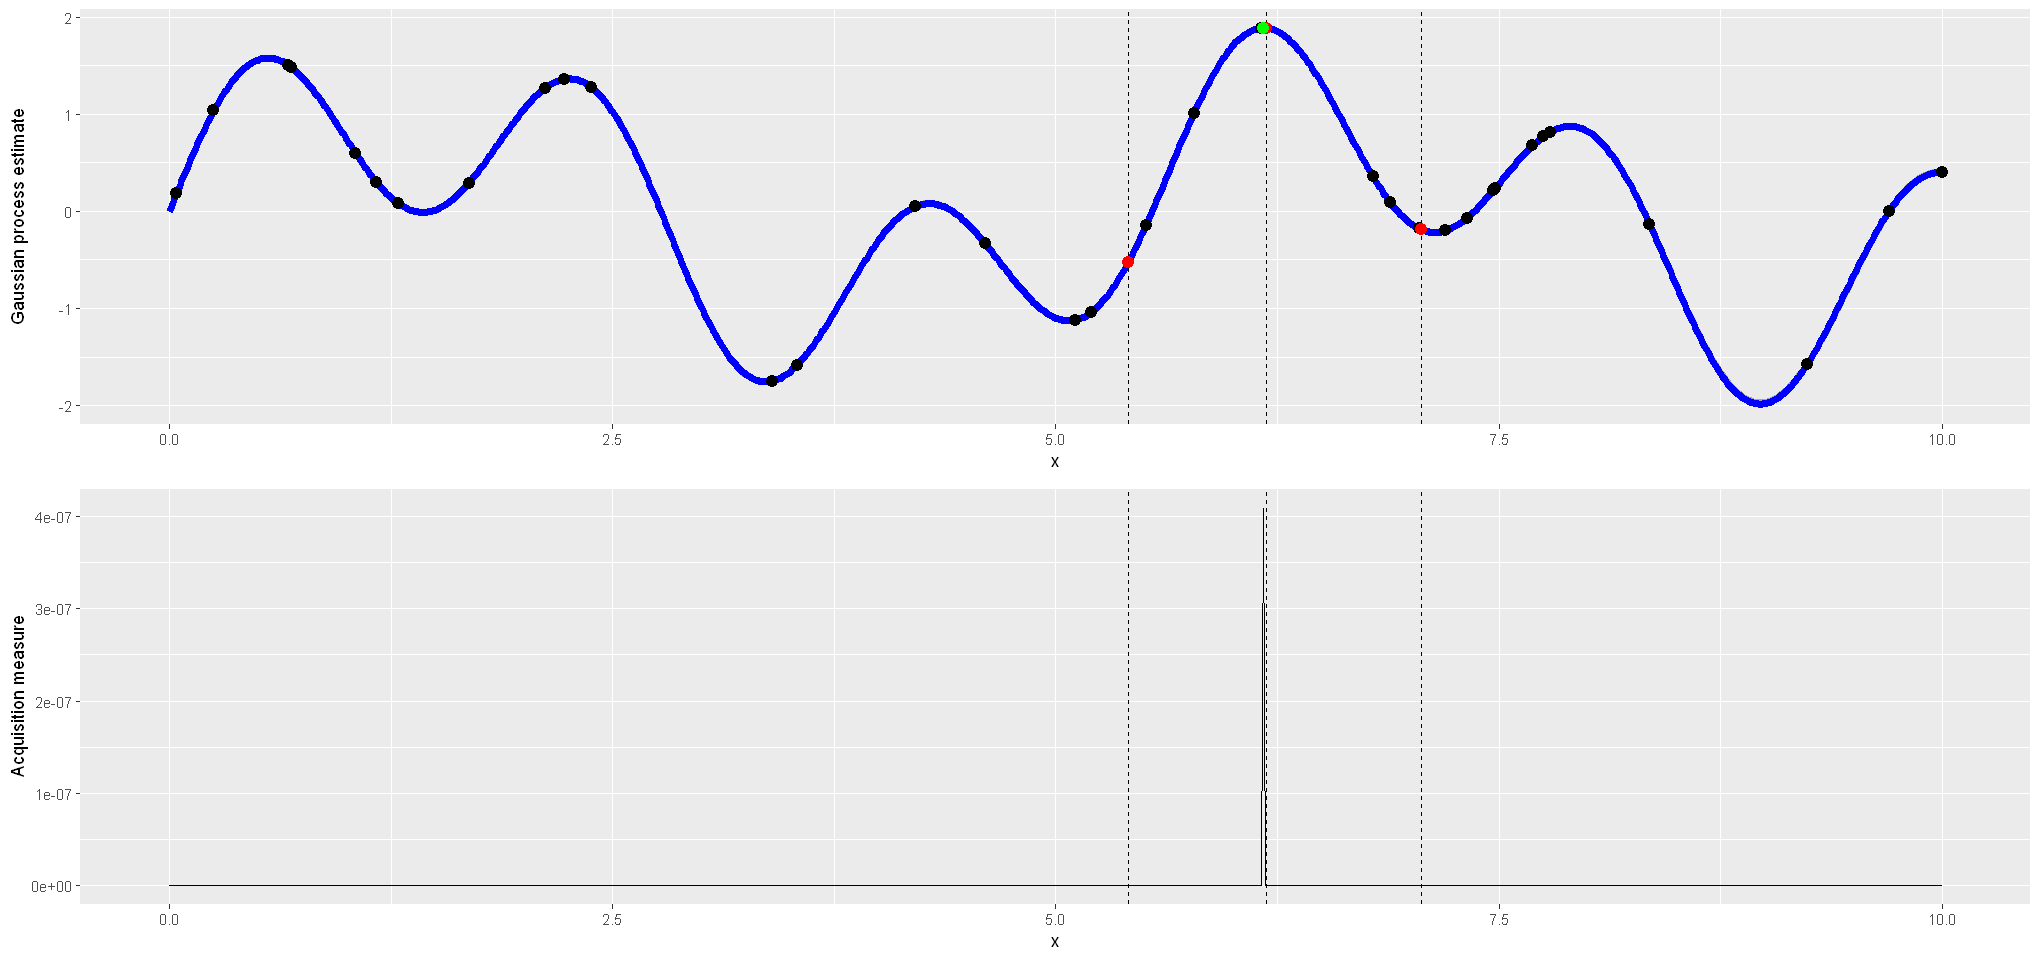

Iteration 14 


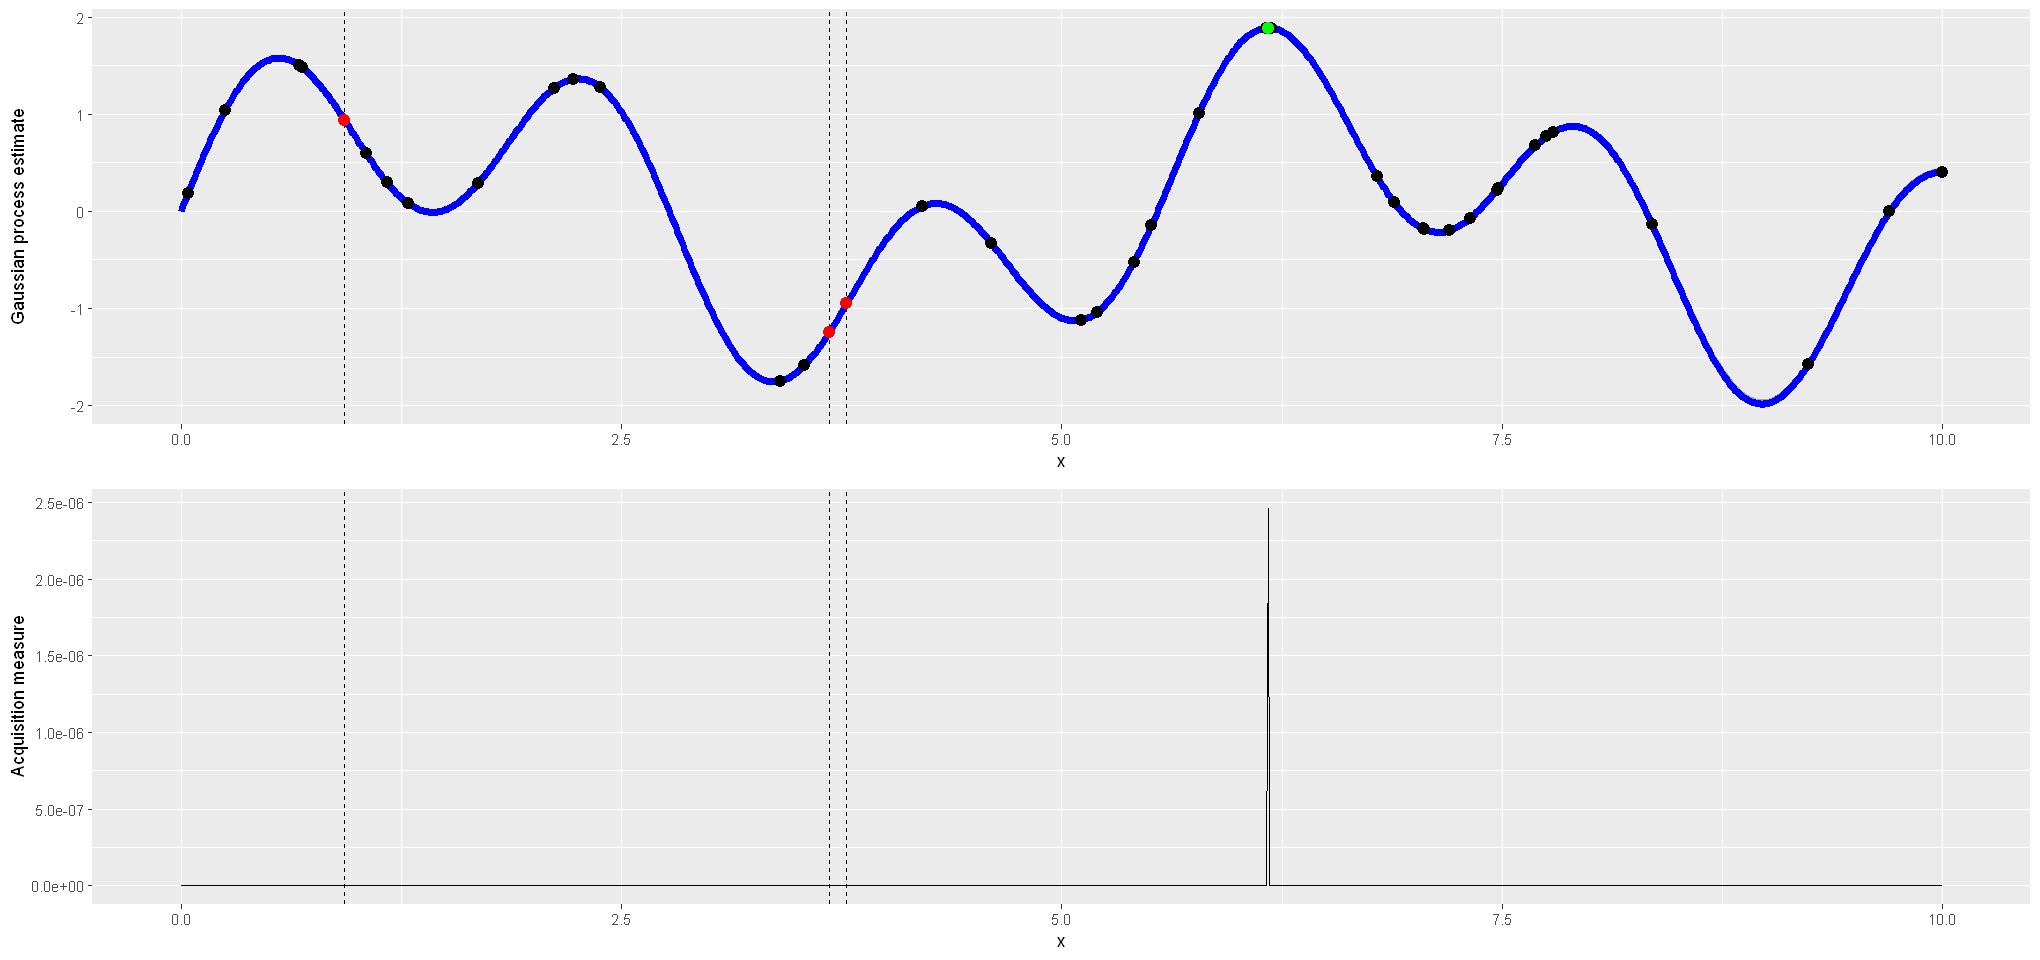

Iteration 15 


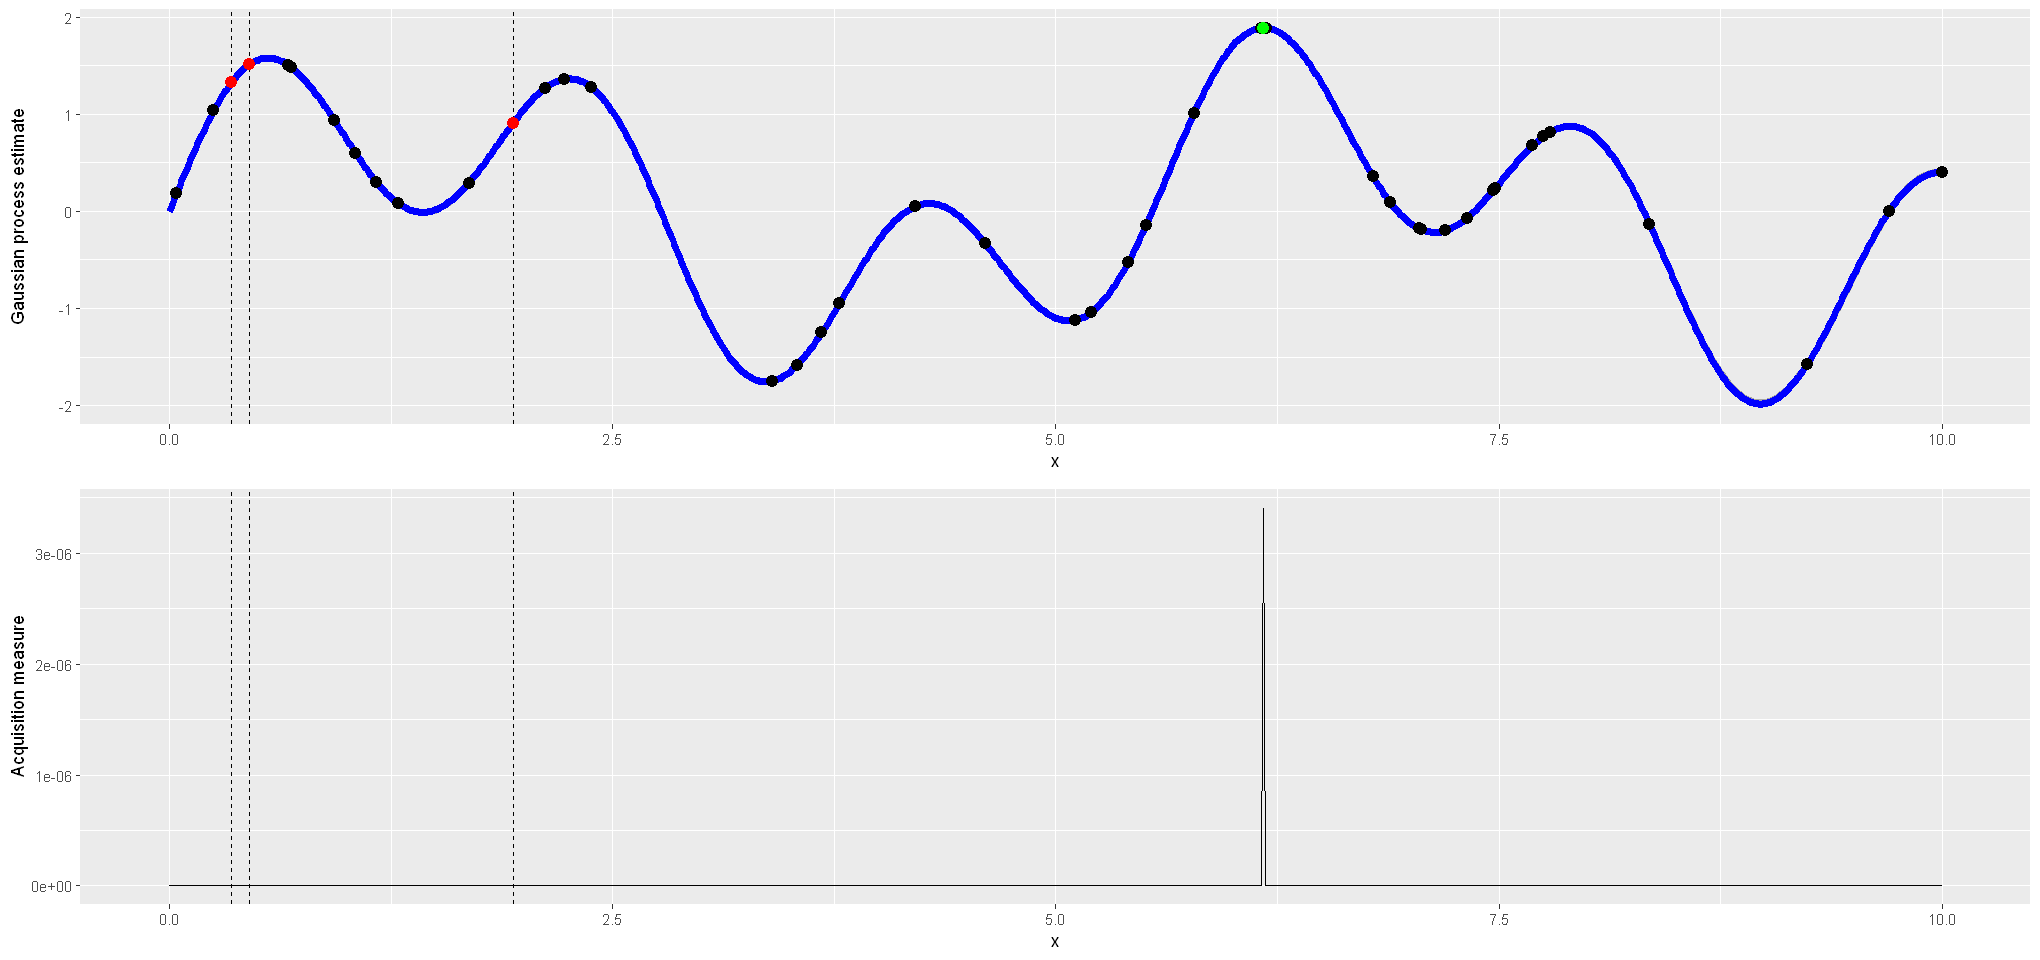

Iteration 16 


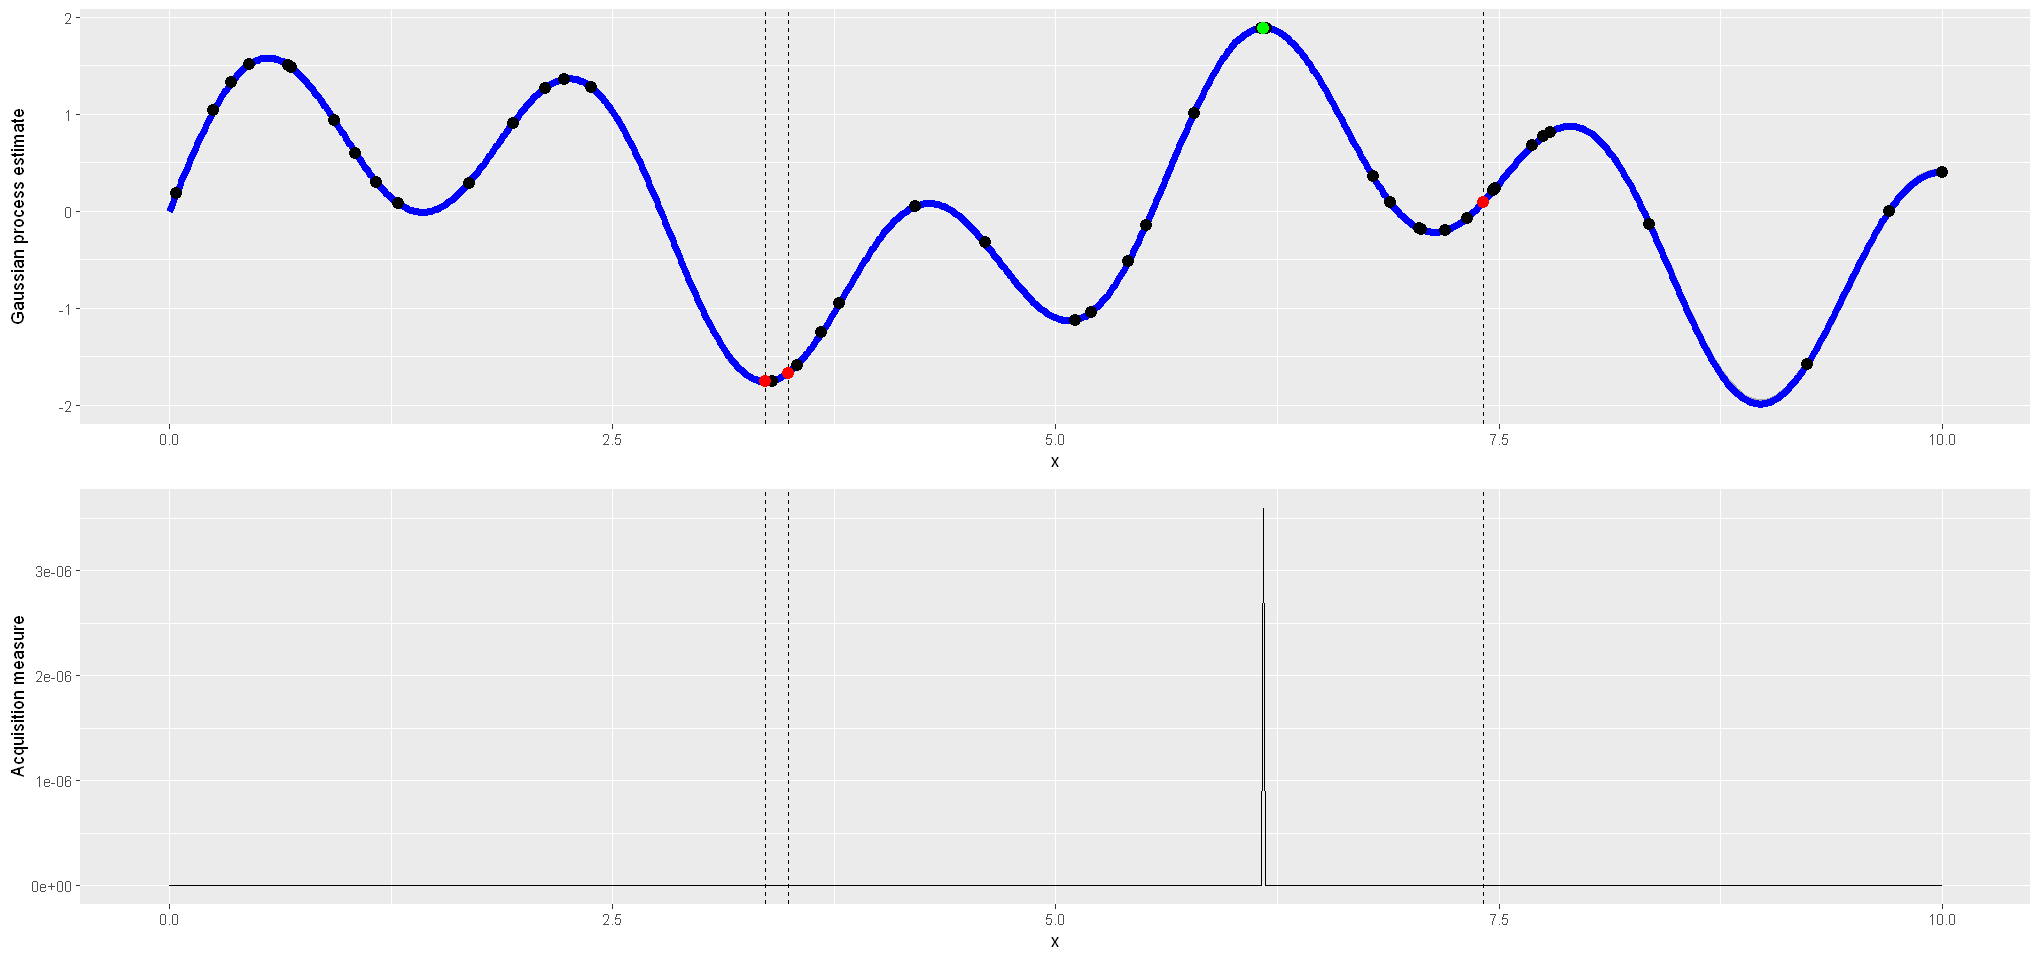

Iteration 17 


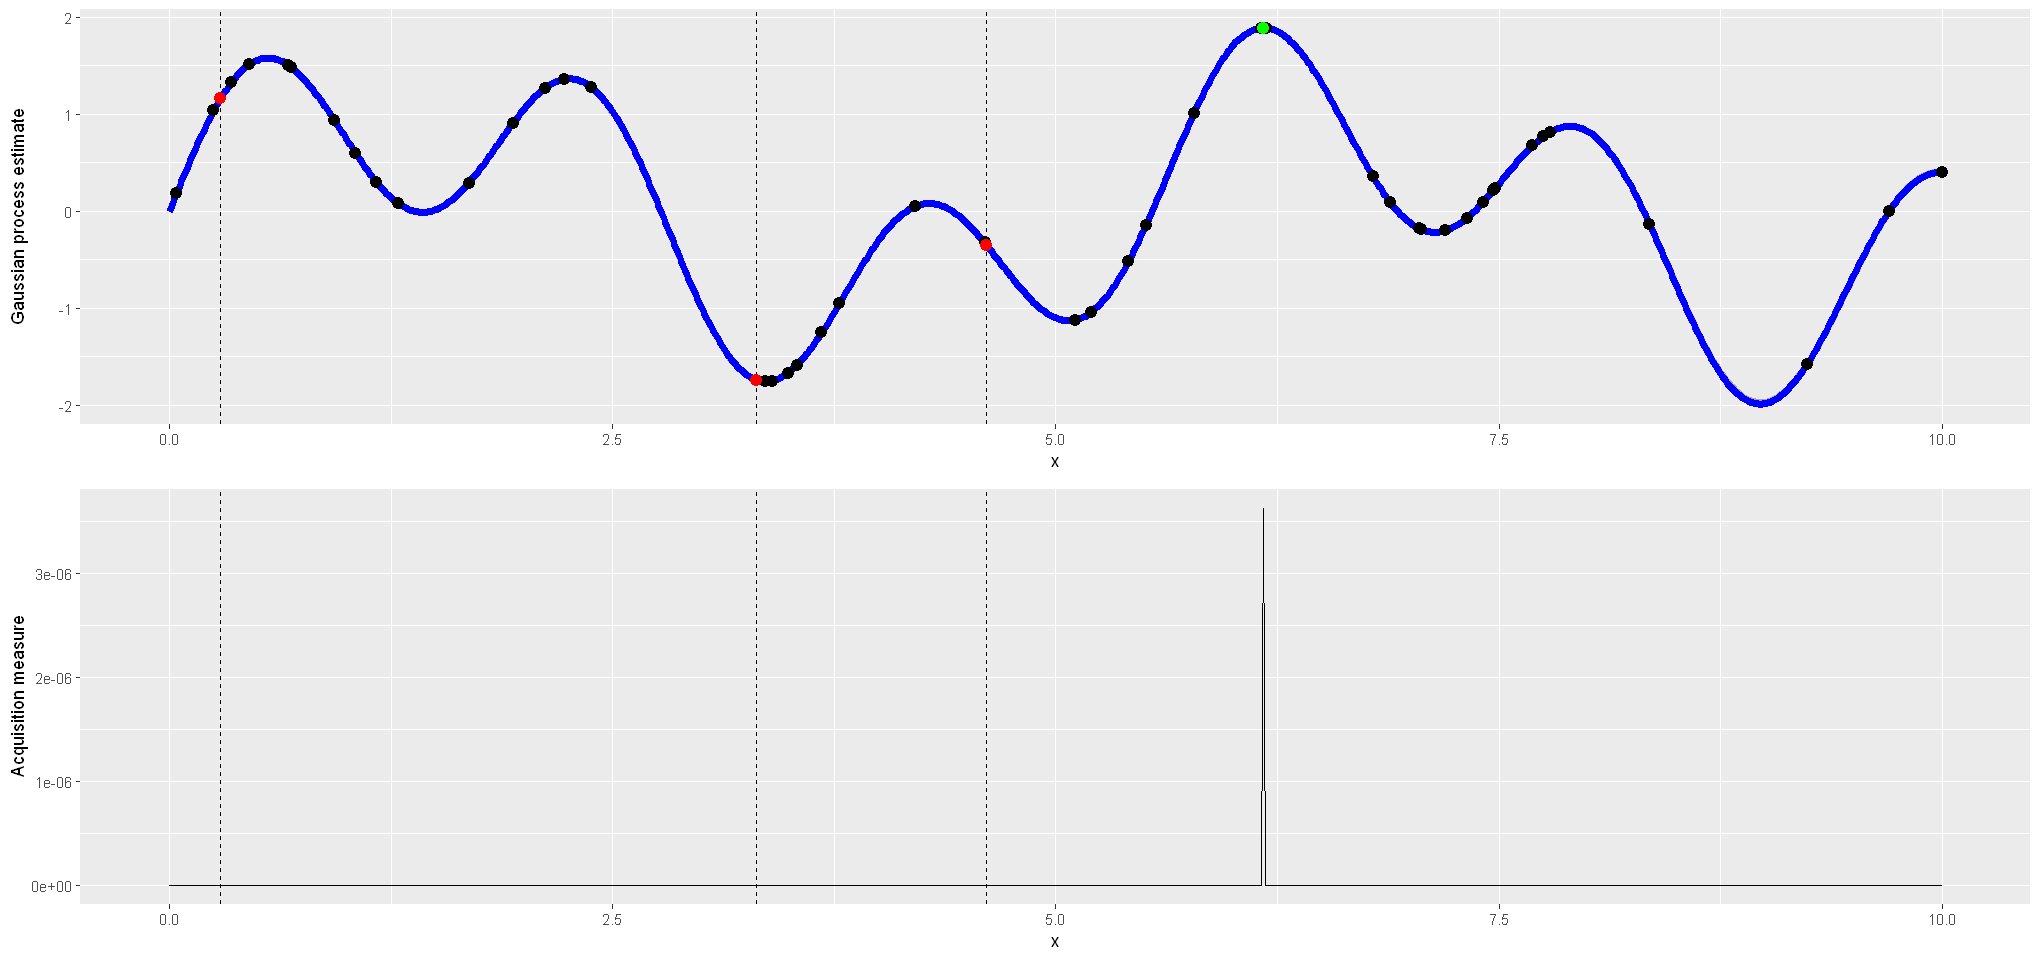

Iteration 18 


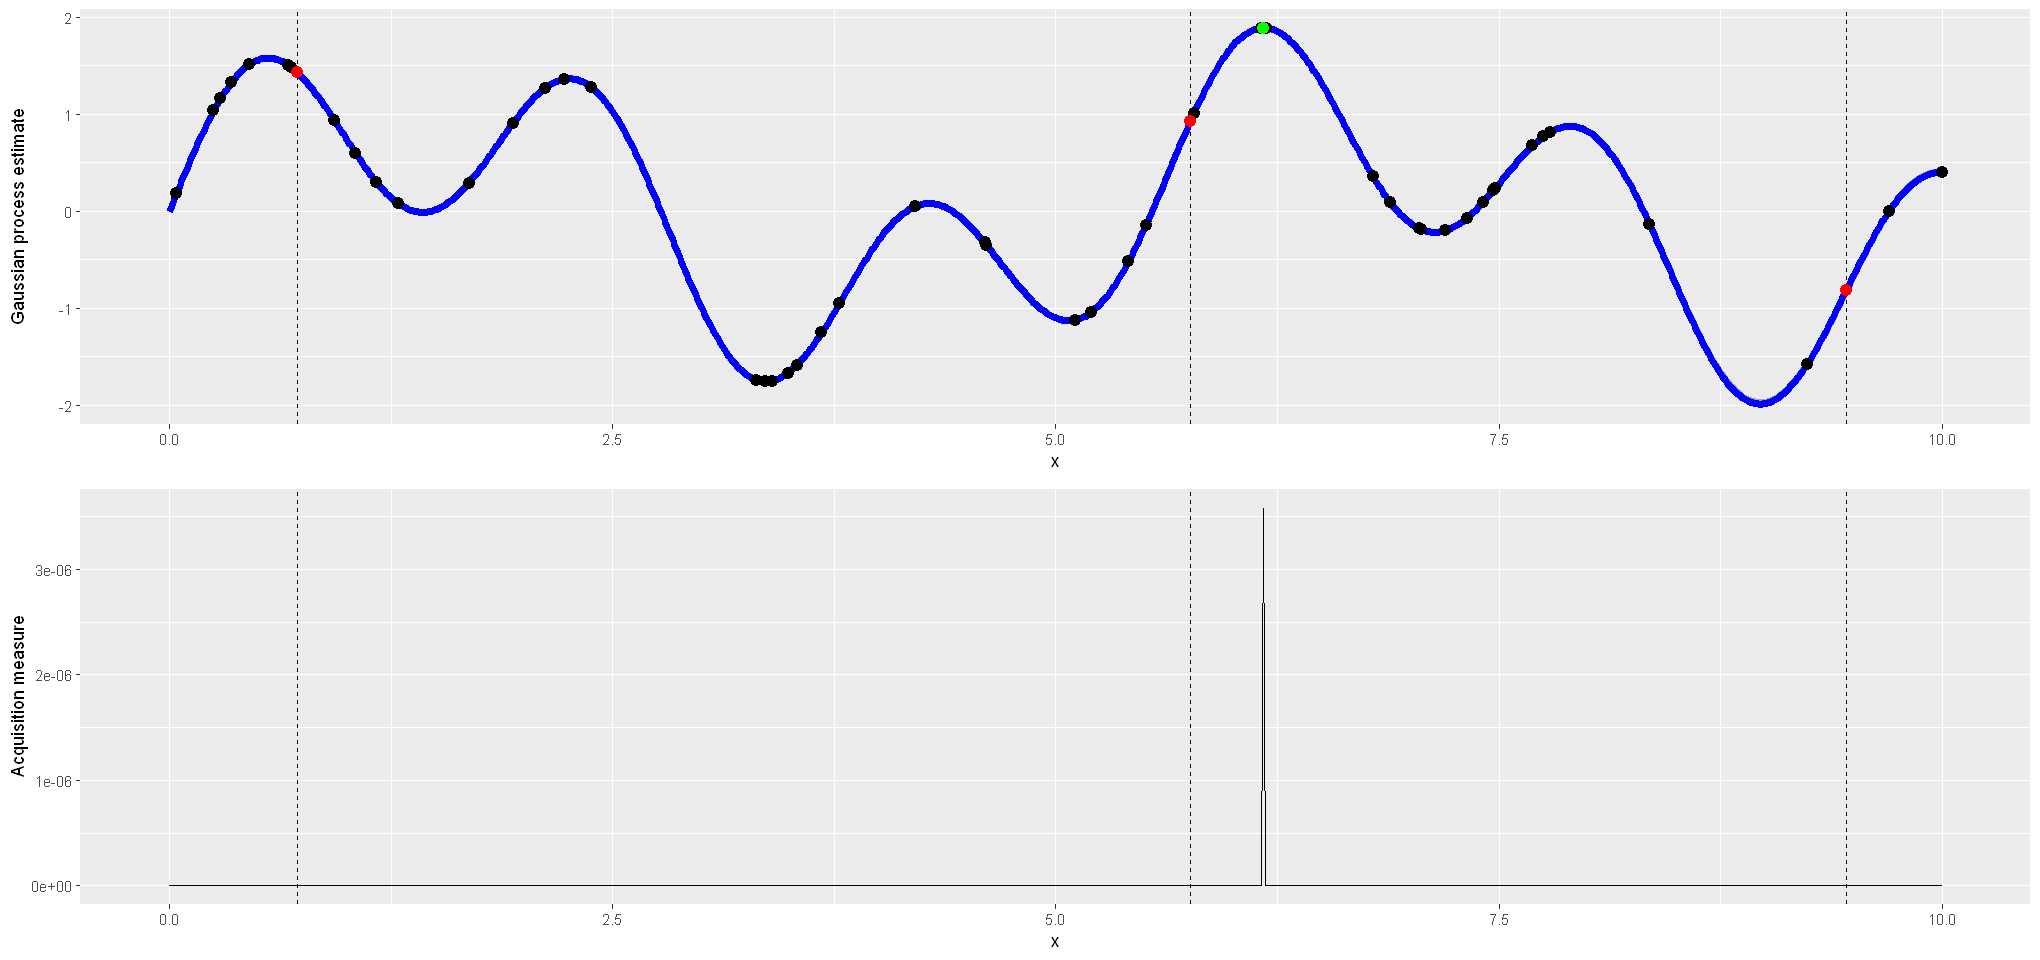

Iteration 19 


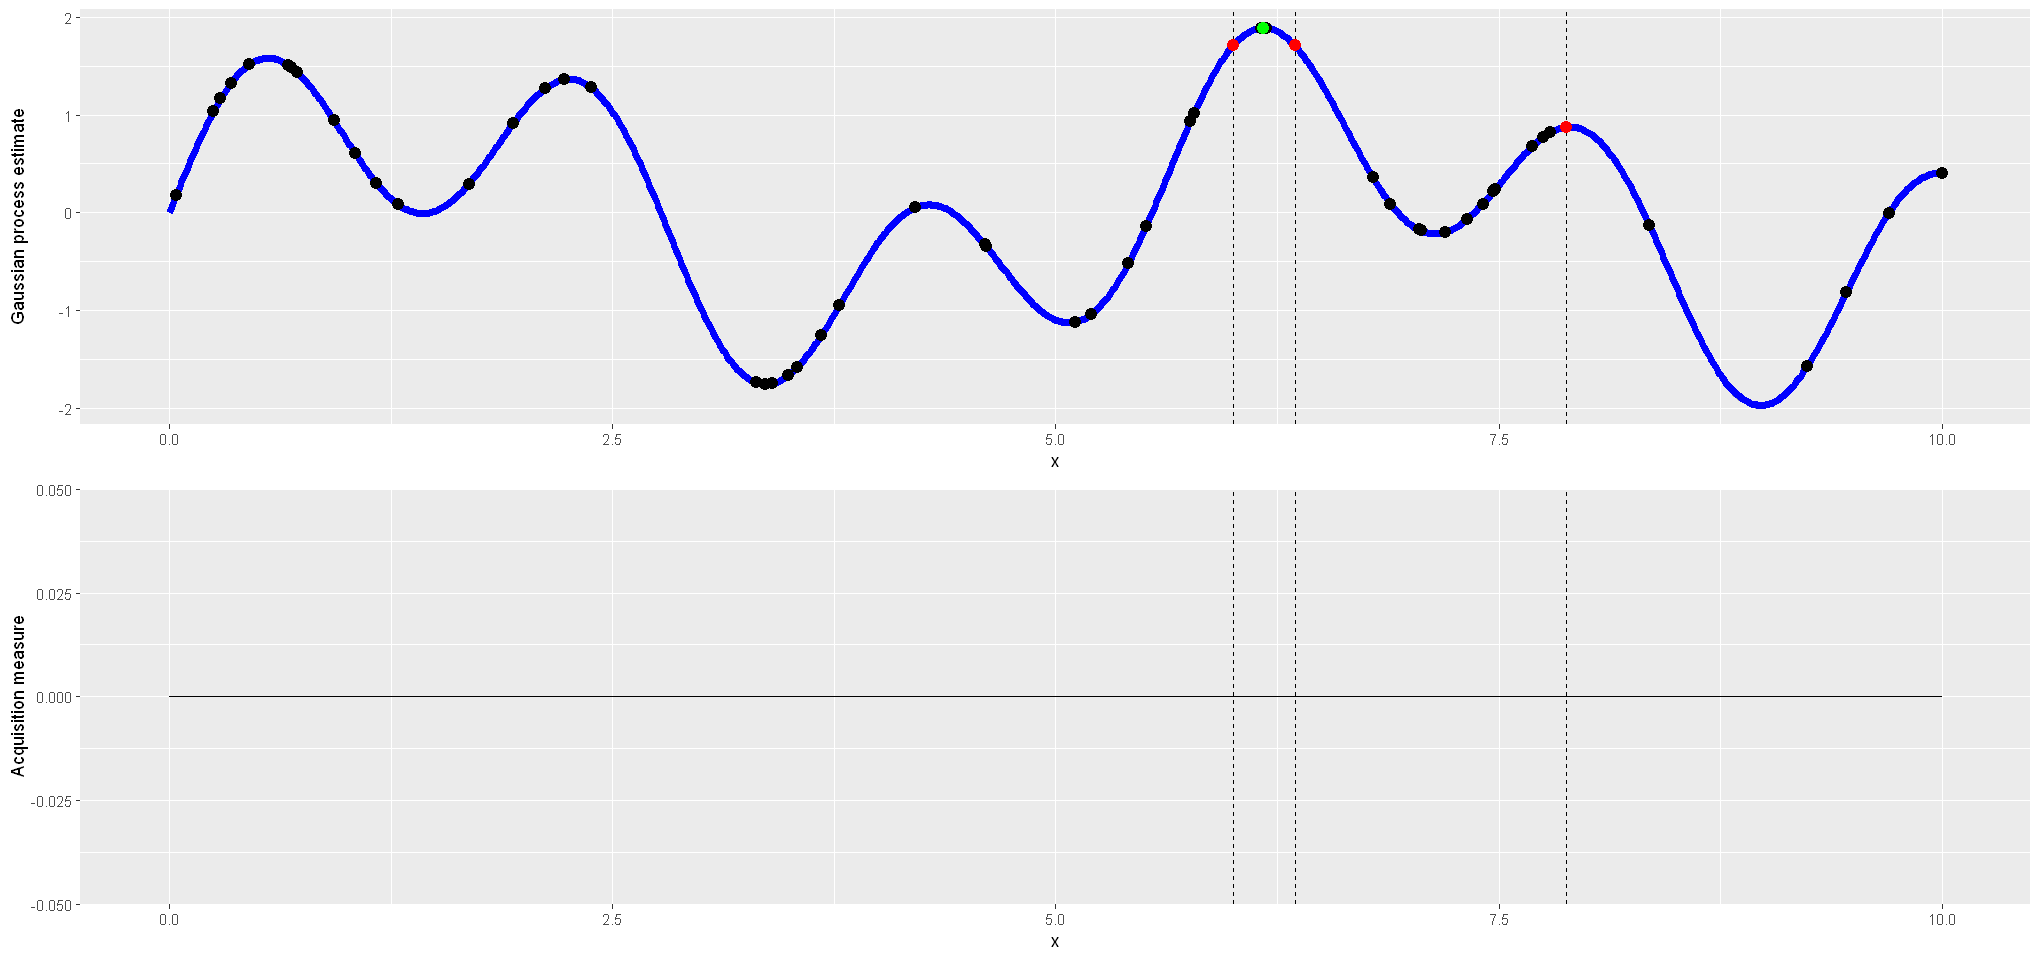

Iteration 20 


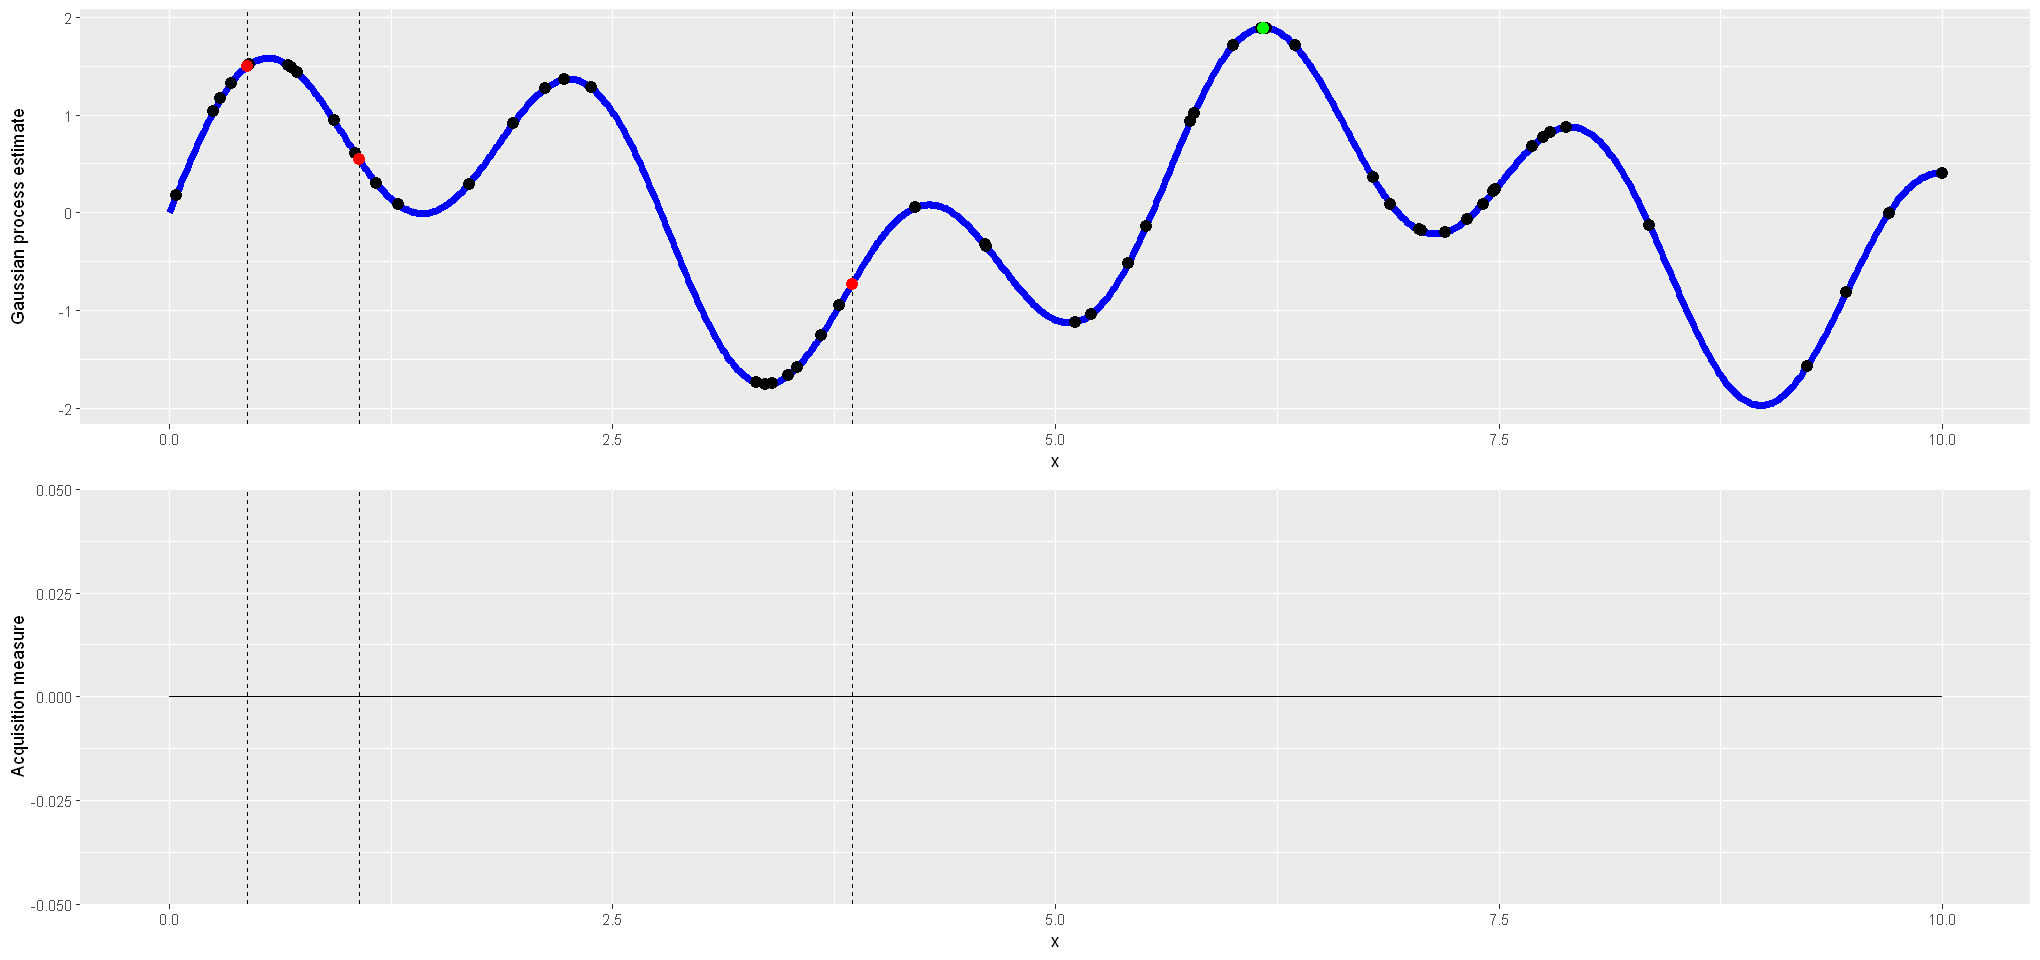

Iteration 21 


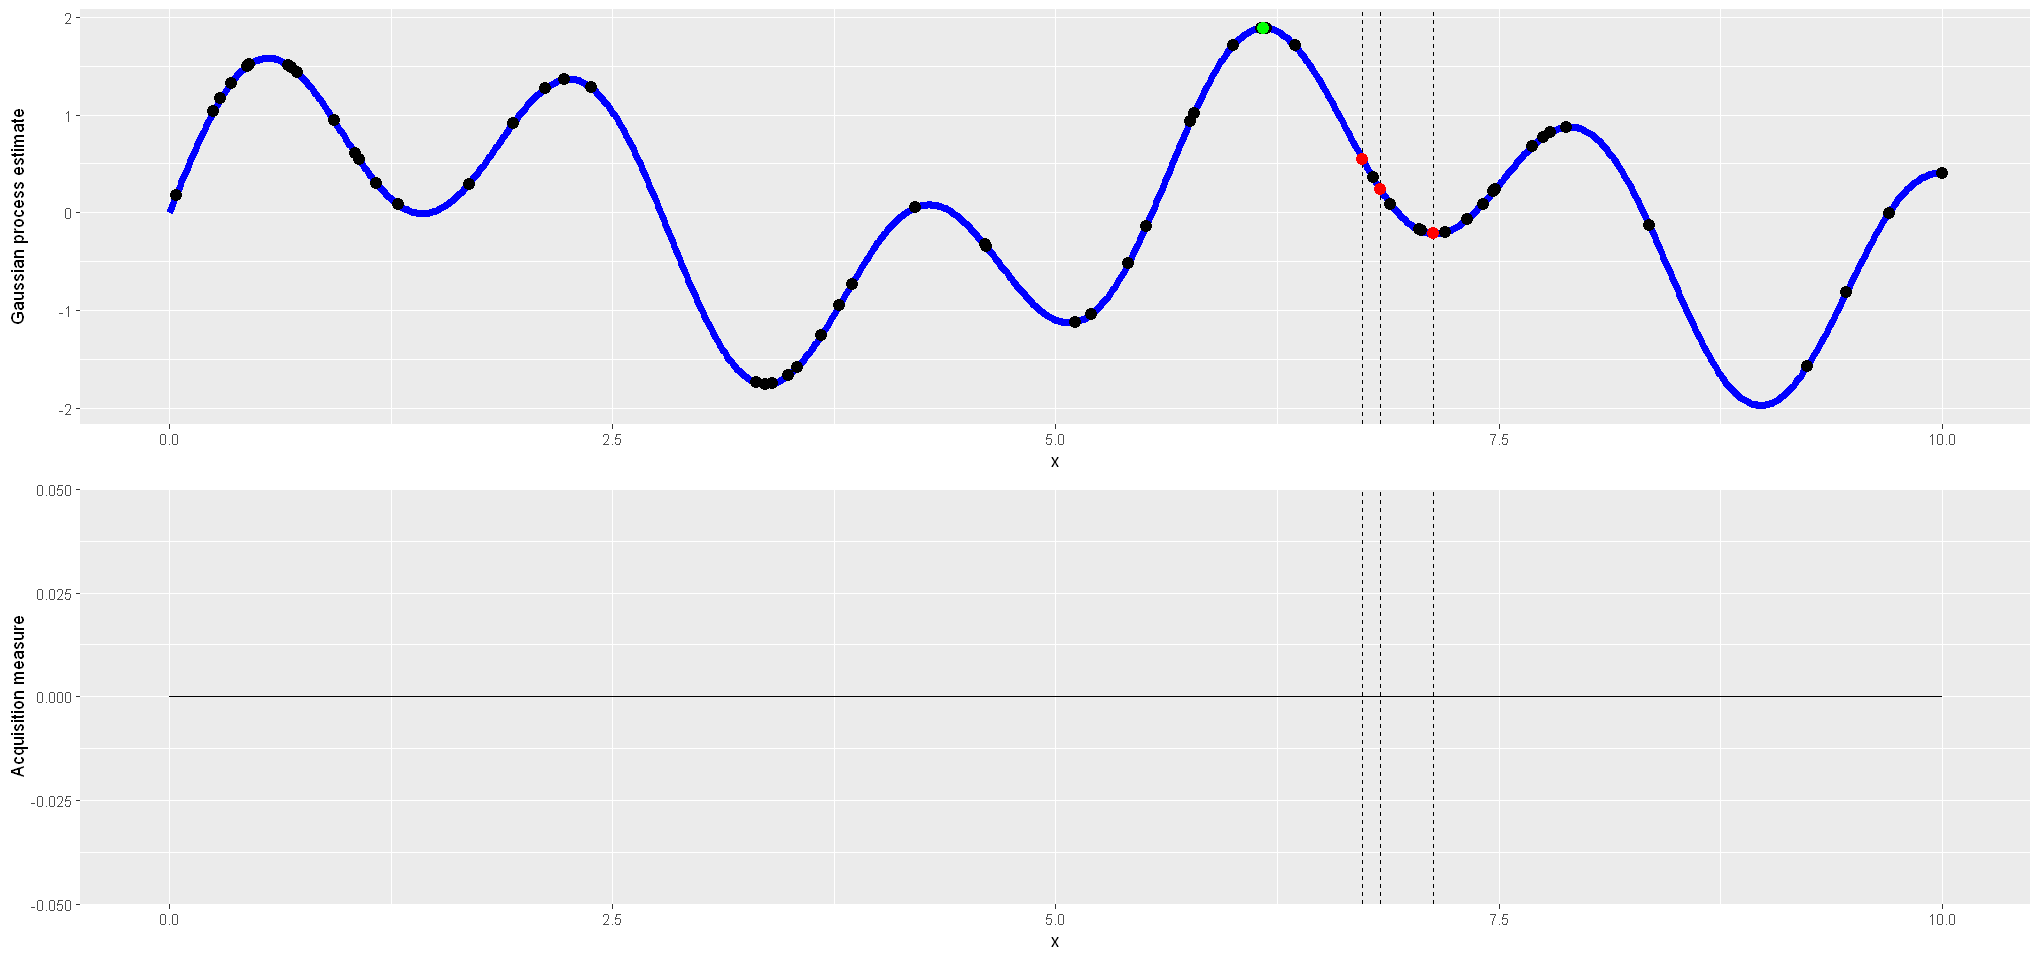

Iteration 22 


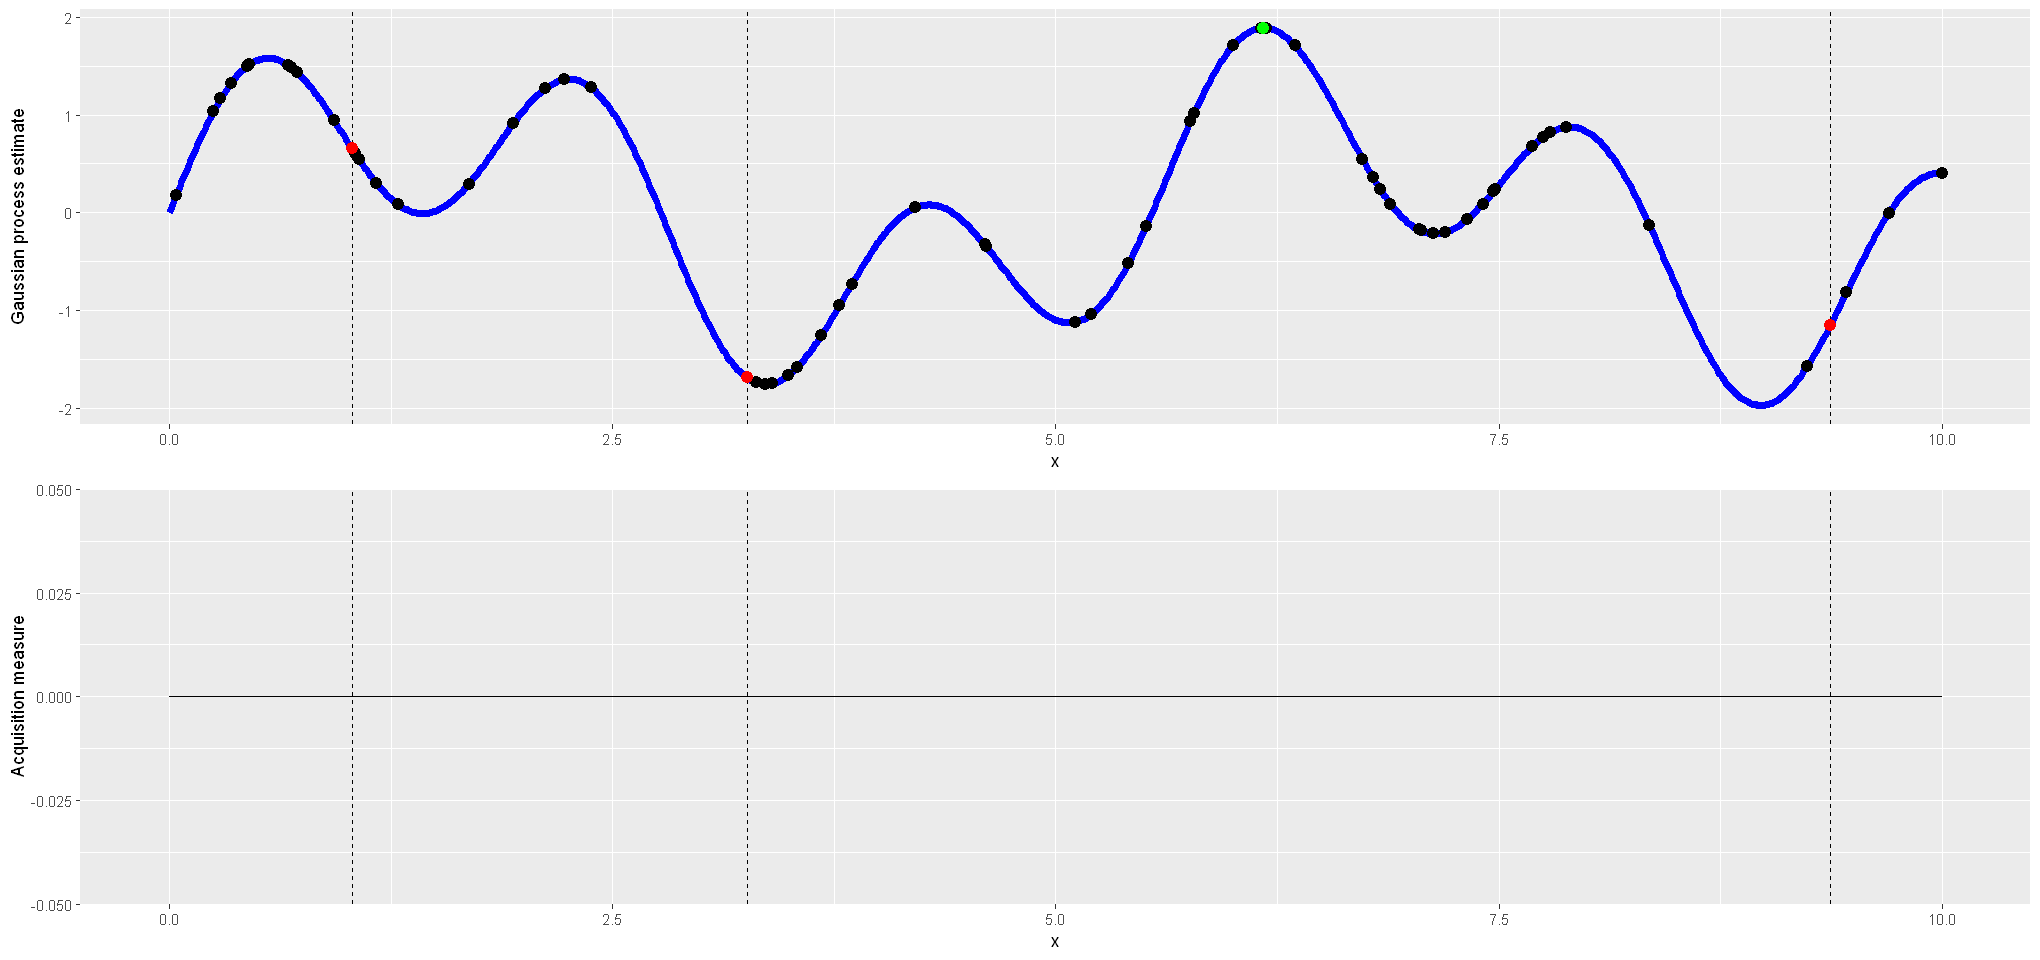

Iteration 23 


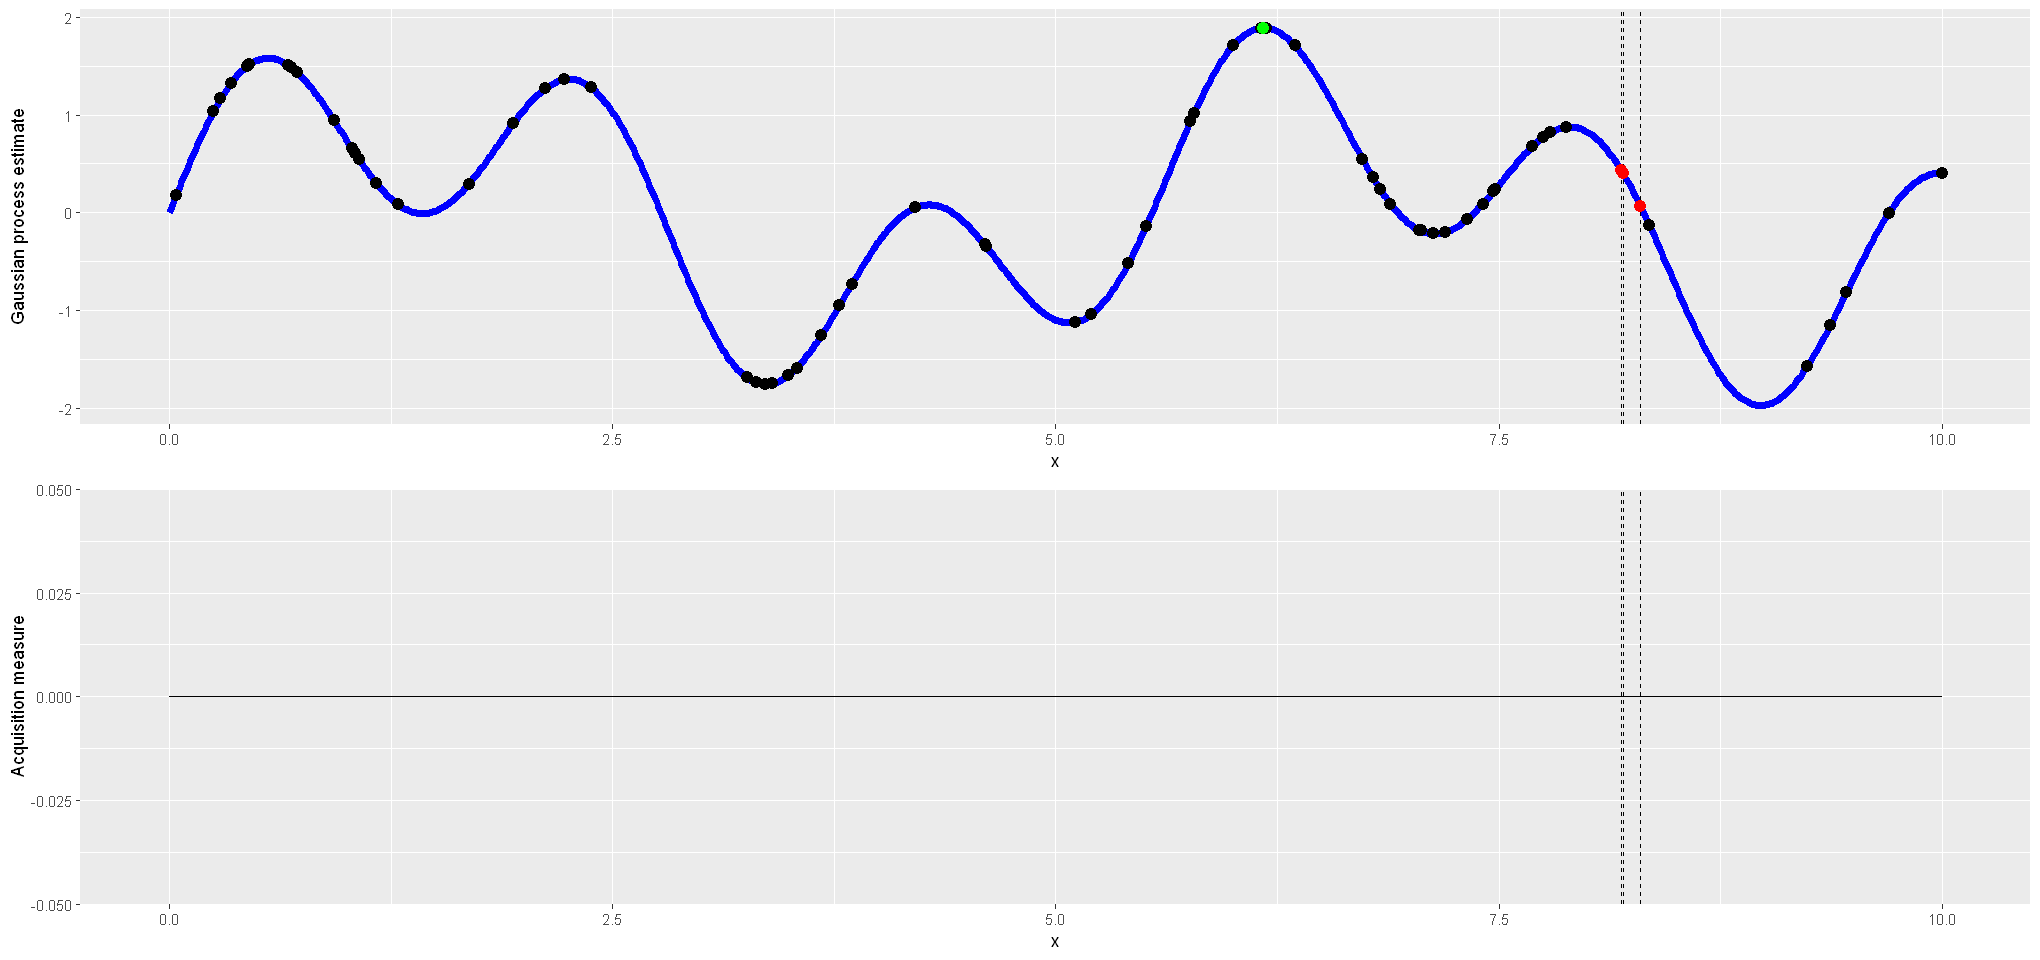

Iteration 24 


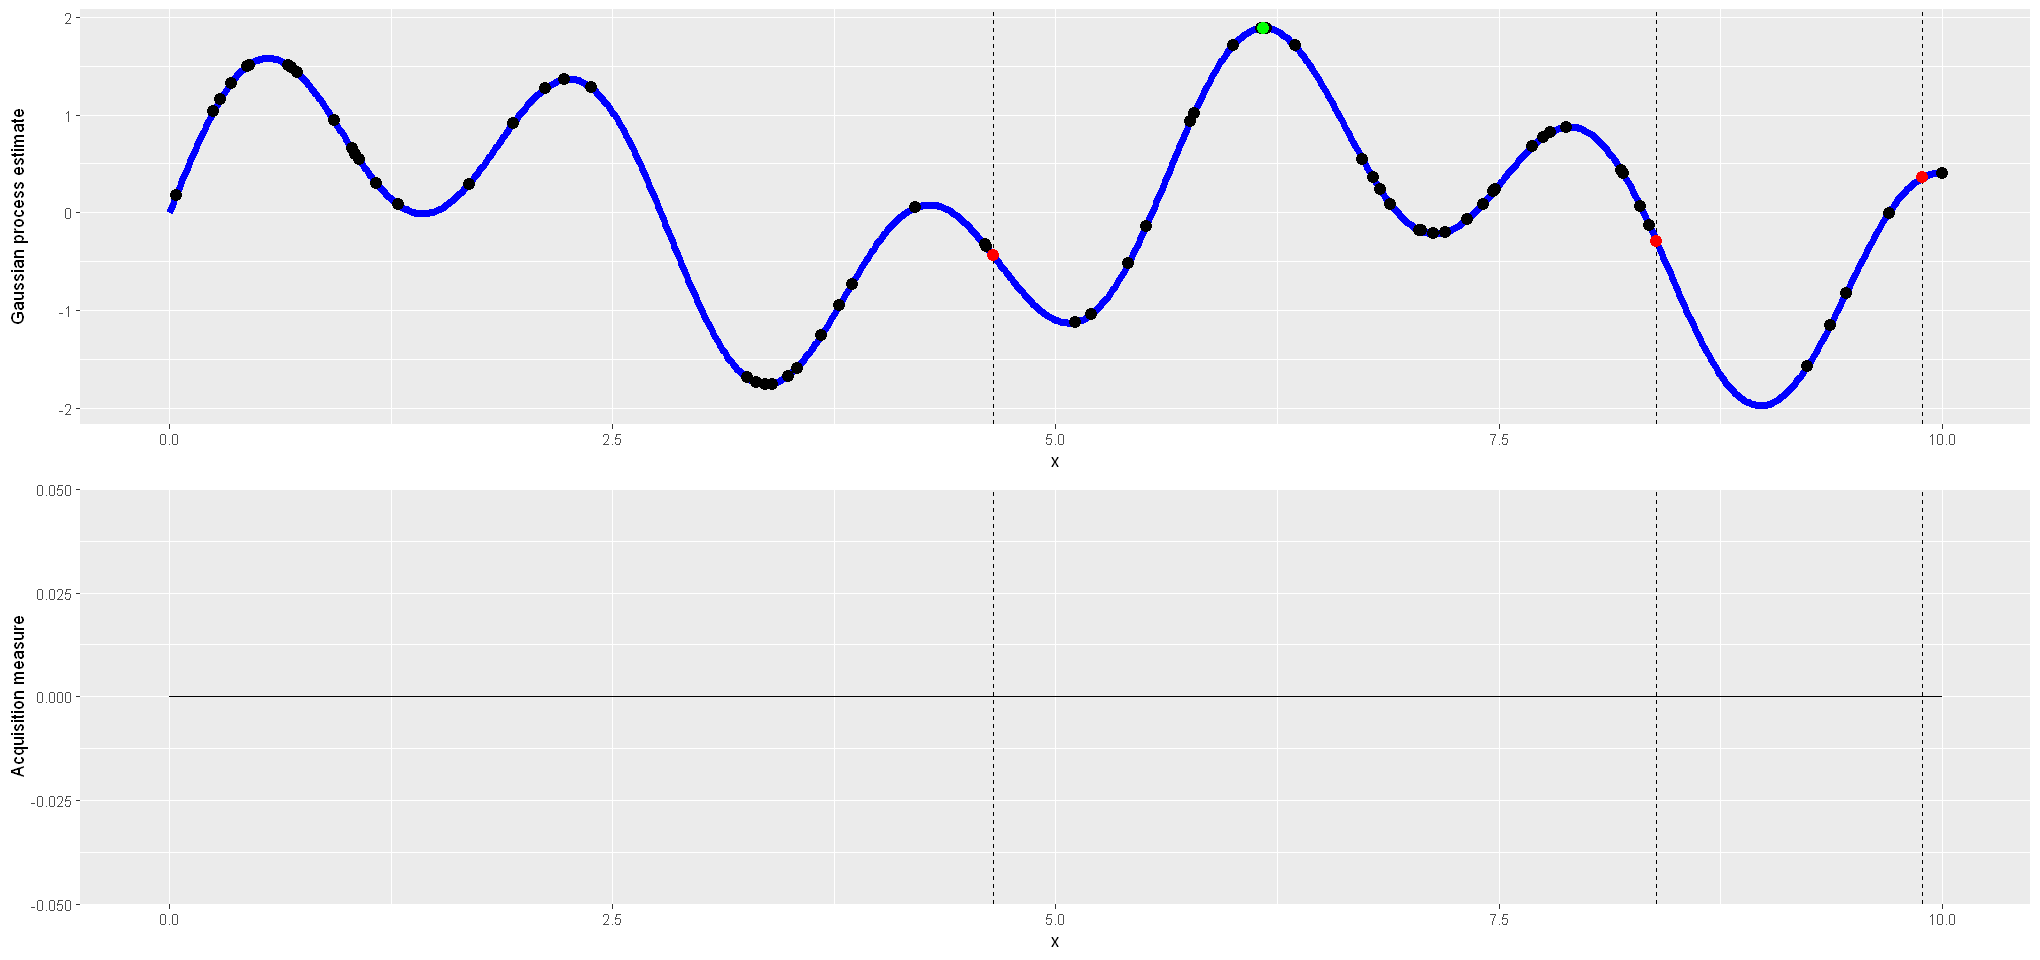

Iteration 25 


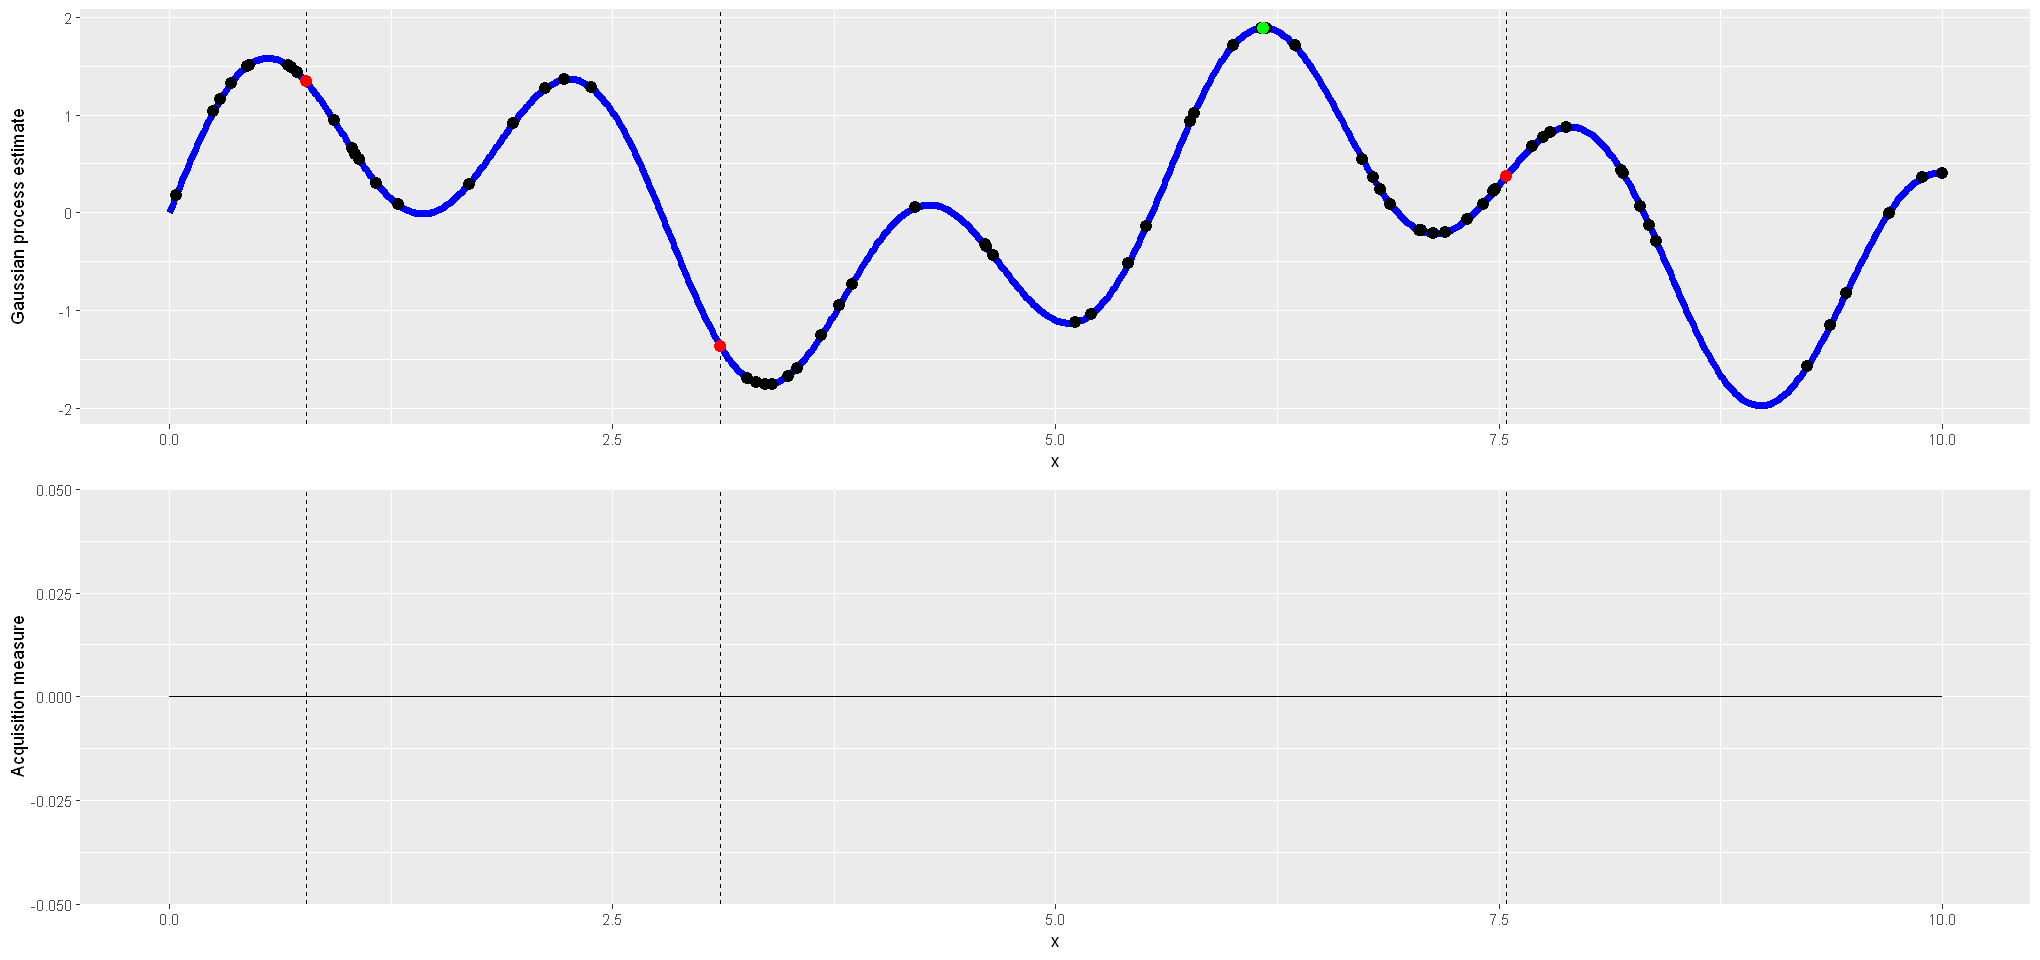

Iteration 26 


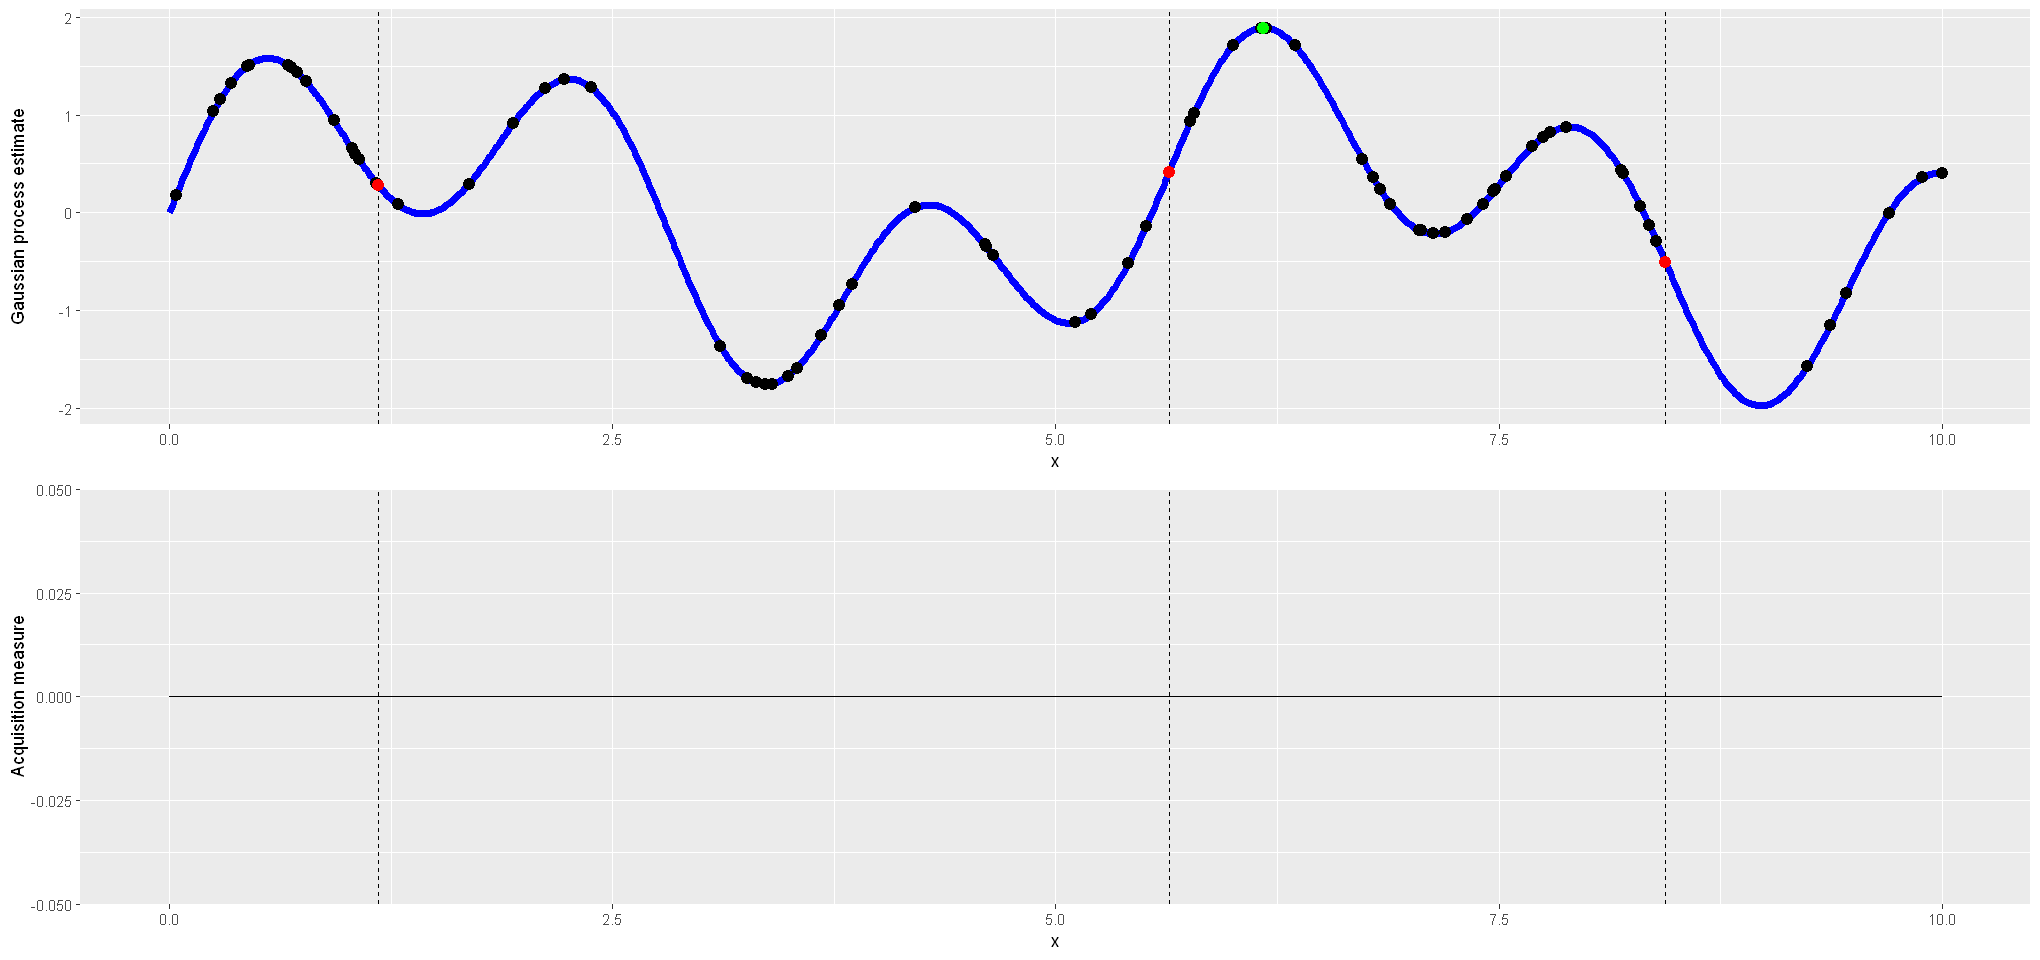

Iteration 27 


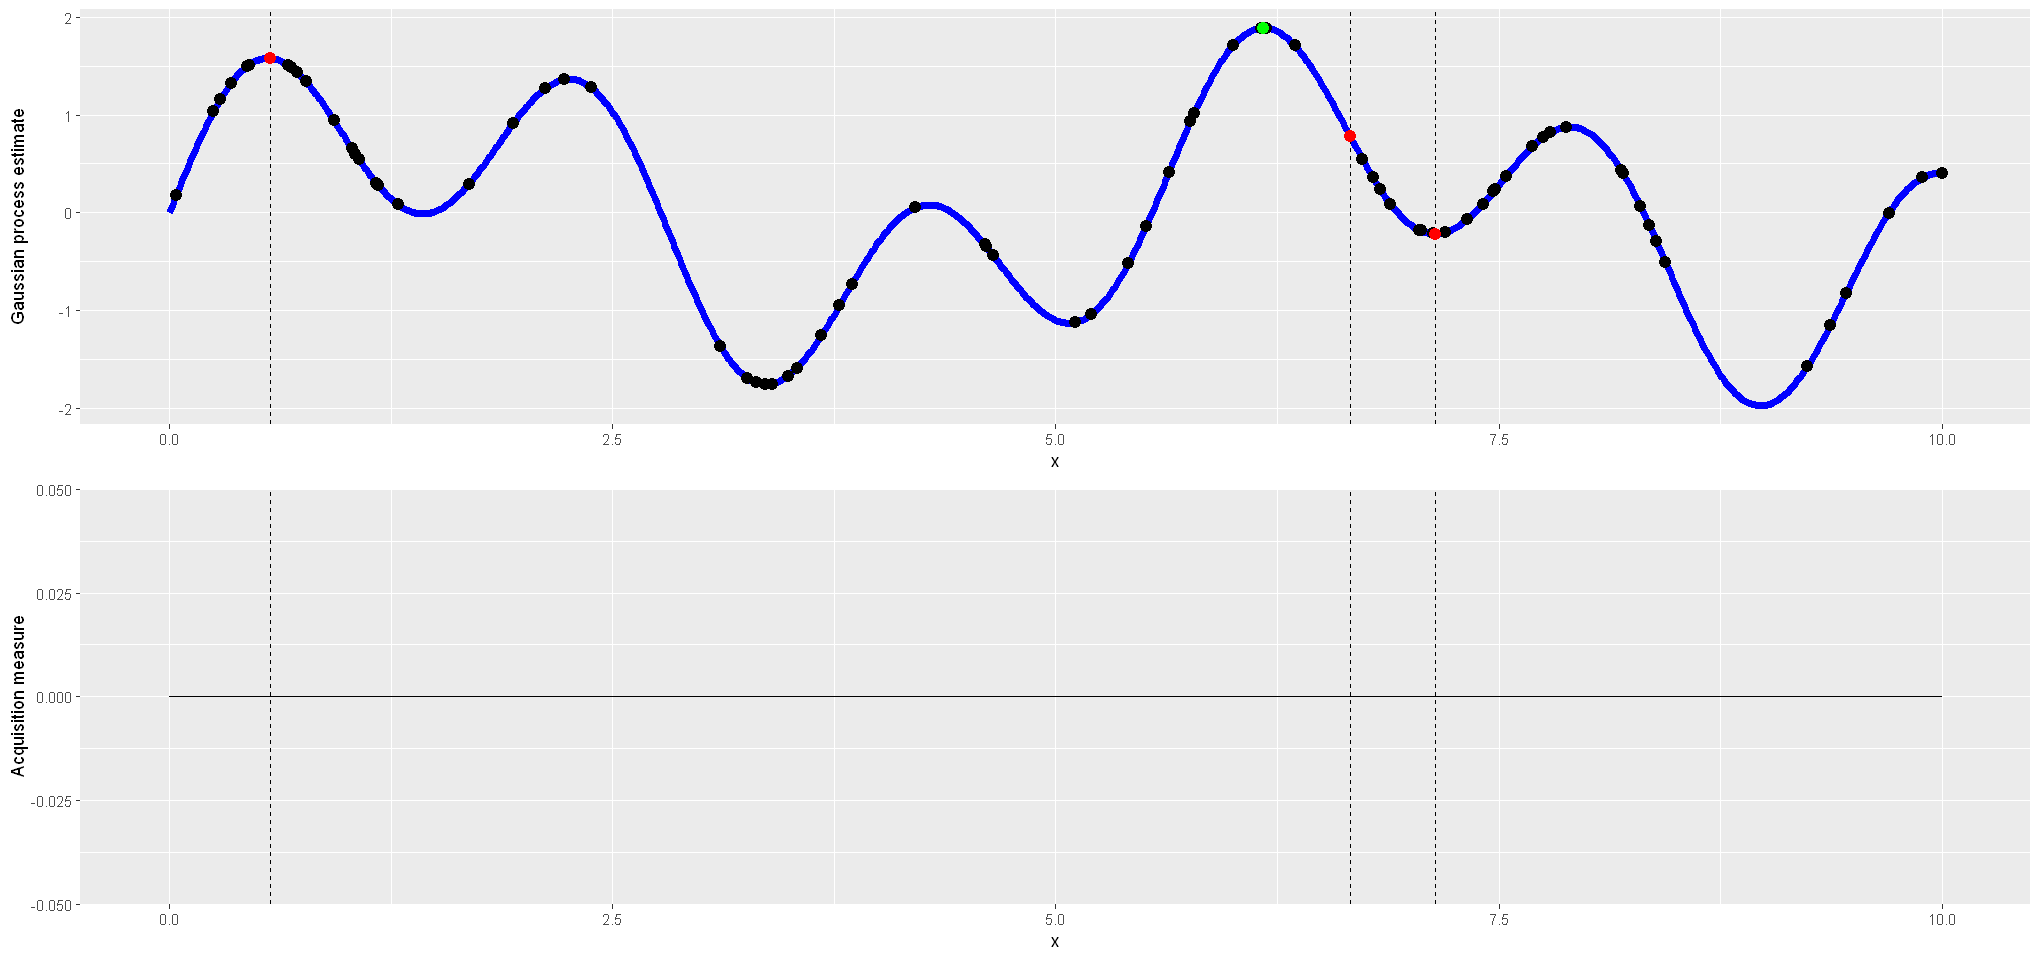

Iteration 28 


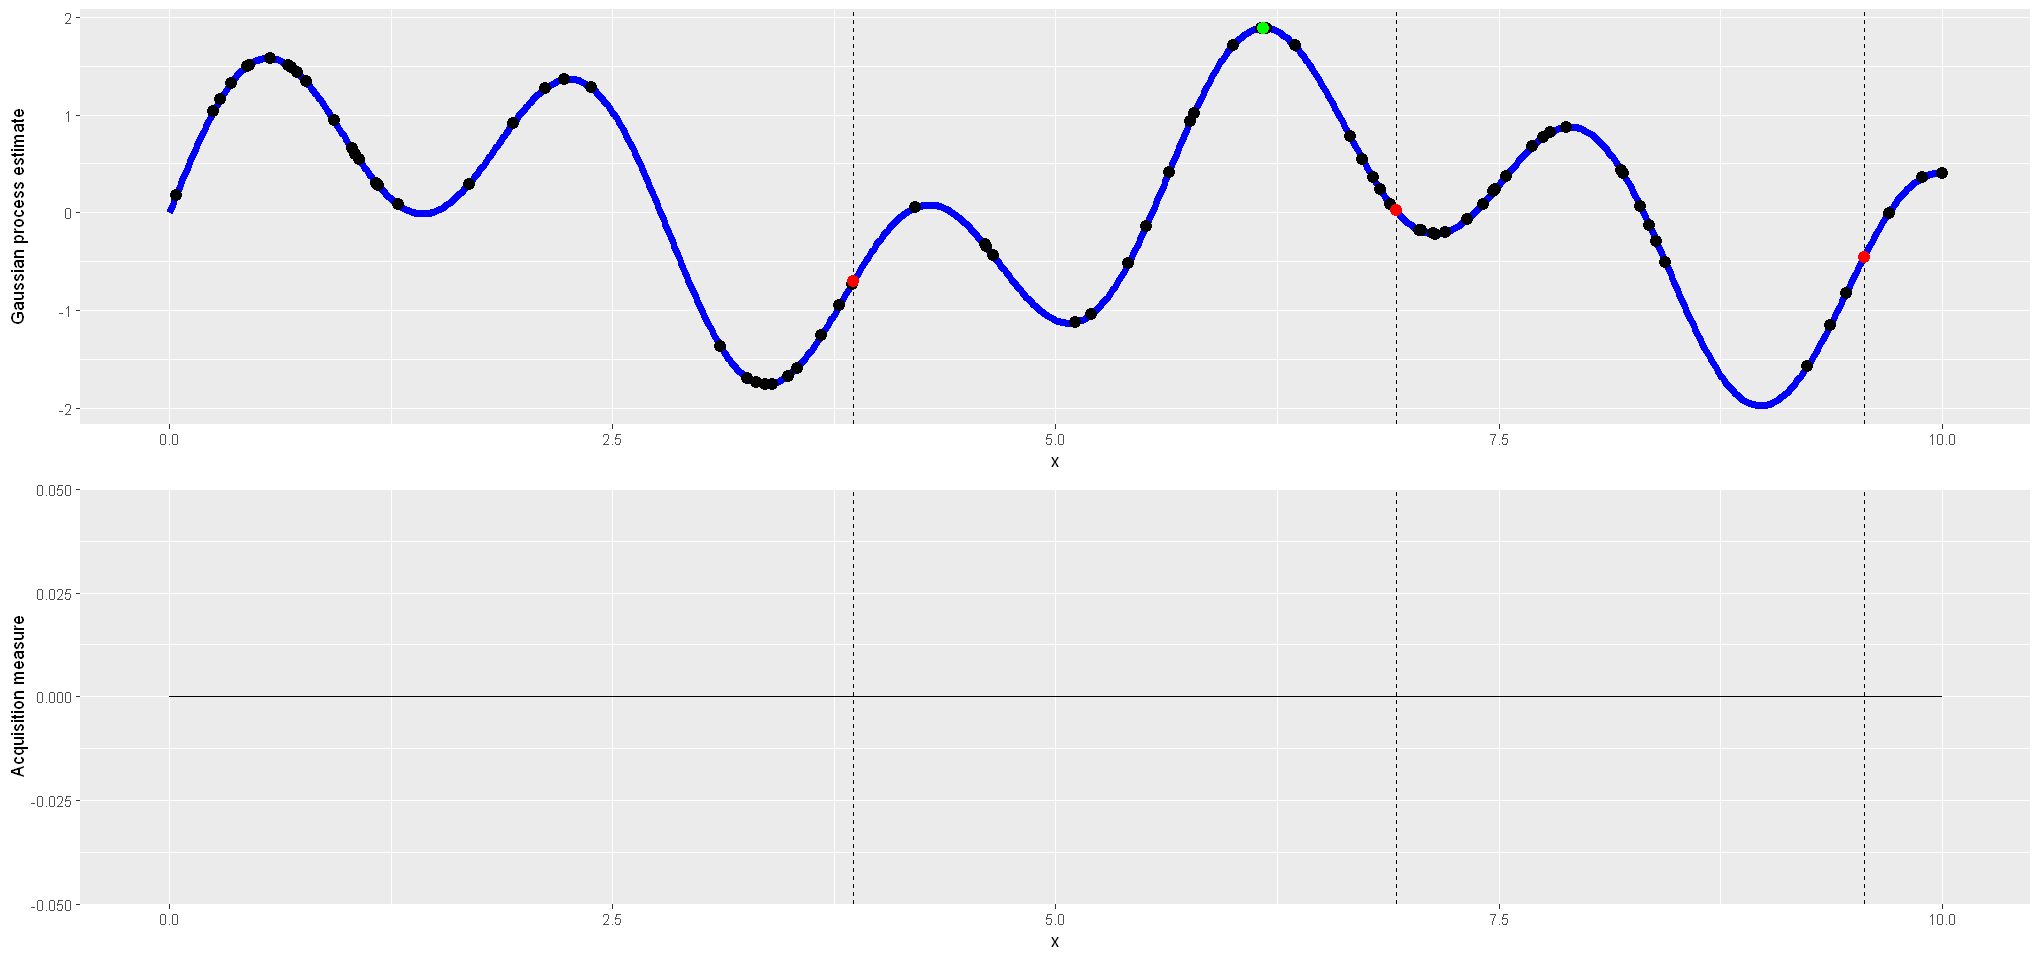

Iteration 29 


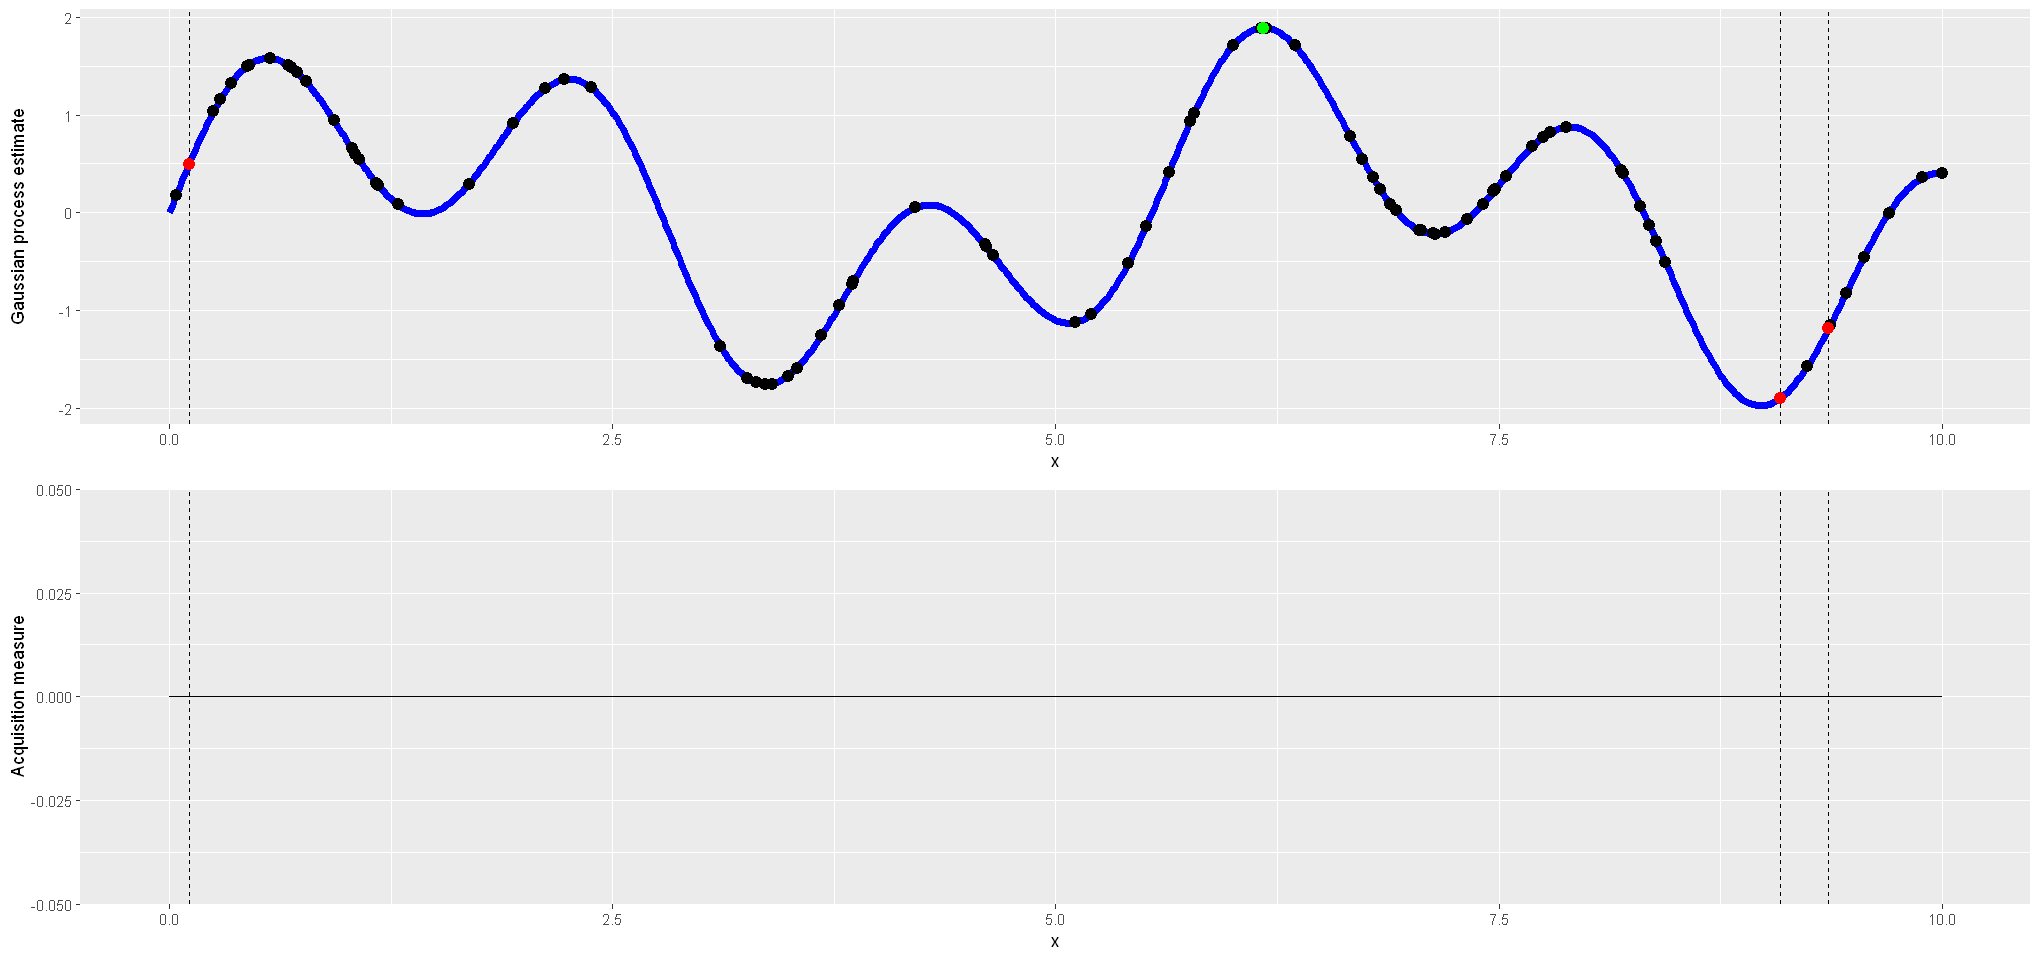

Iteration 30 


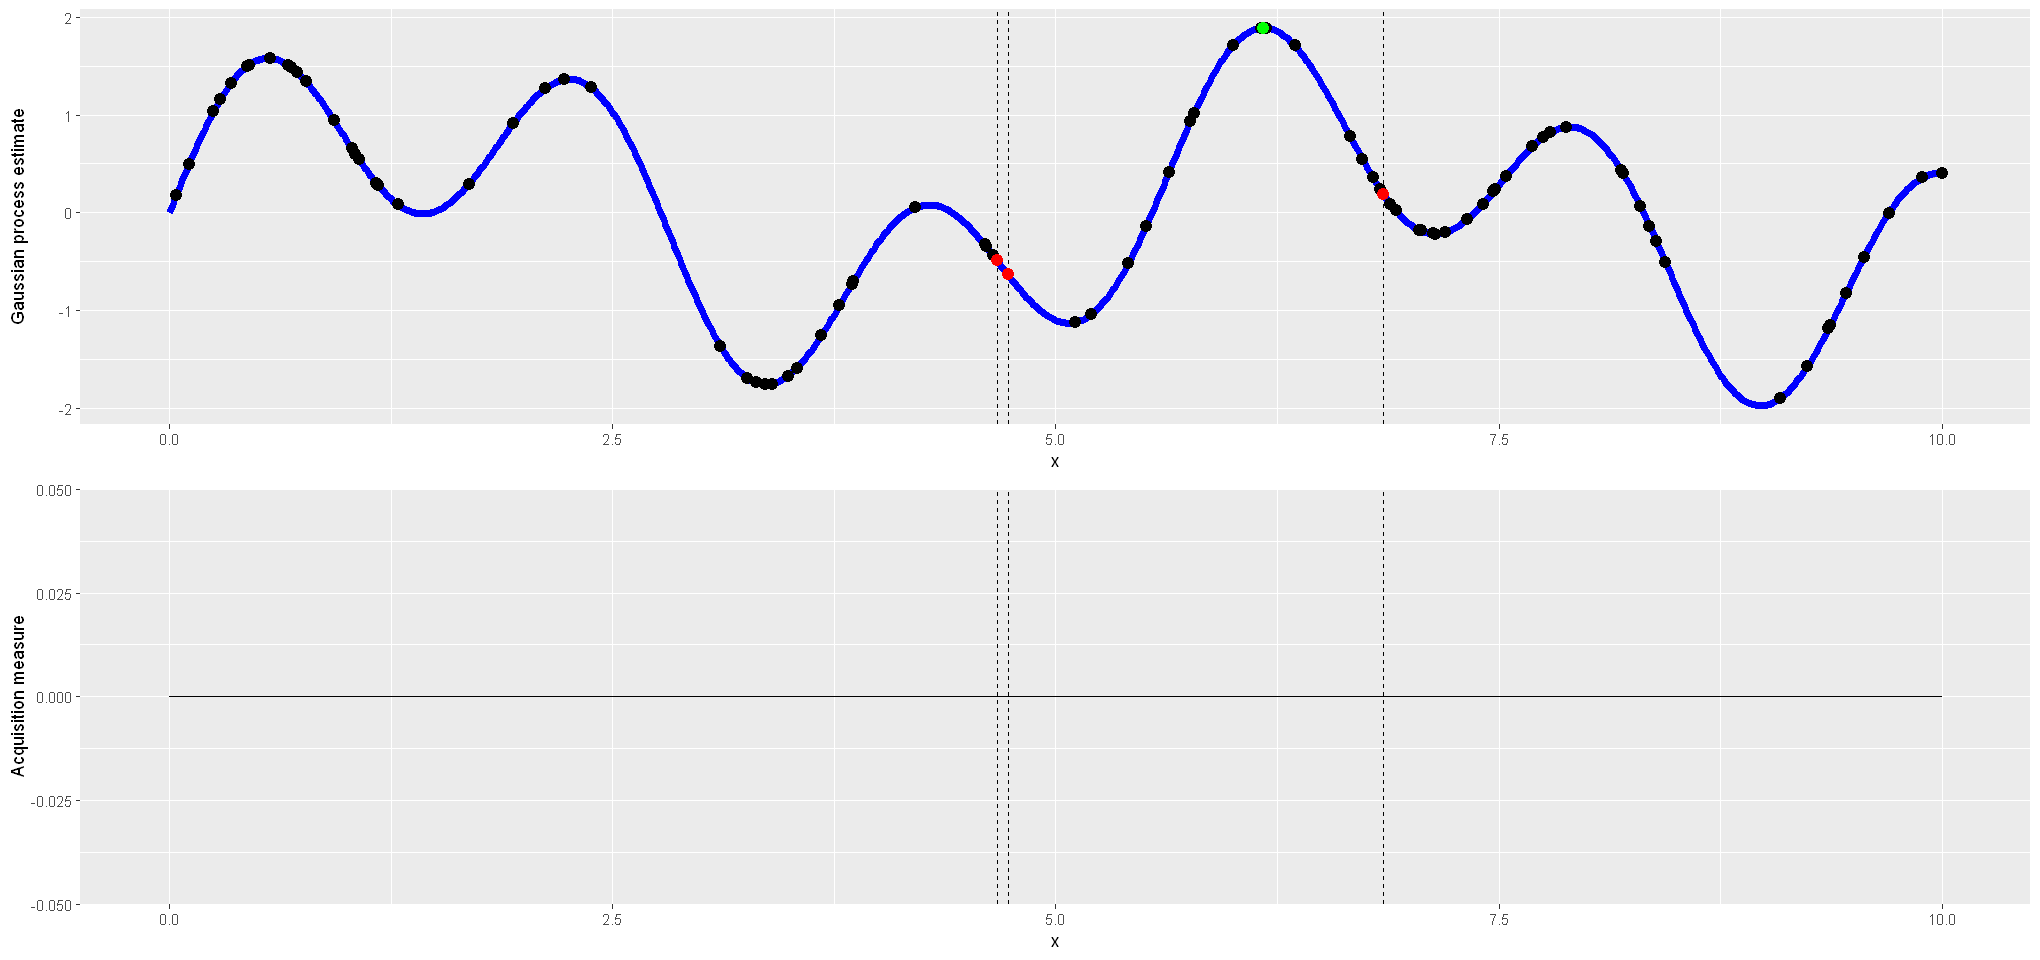

In [19]:
observed.x <- numeric(0)
observed.y <- numeric(0)

set.seed(1)

for(n in seq(n.iterations)) {
  gp.model <- calculate.regression.model(observed.x, observed.y)
  
  xx <- c(x.plt, observed.x)
  xx <- xx[!duplicated(xx)]
  xx <- xx[order(xx)]
  yy.acq <- sapply(xx, function(x) acq.func(gp.model, x))
  
  next.evaluation.points <- choose.next.evaluation.points(xx, yy.acq, observed.x, gp.model)
  
  yy <- sapply(xx, function(x) gp.model$mean(x))
  ss <- sapply(xx, function(x) sqrt(max(gp.model$cov(x)[1,1], 0)))
  
  
  df <- data.frame(x=xx, y=yy, ymin=yy-ss, ymax=yy+ss)
  points.df <- data.frame(x=observed.x, y=observed.y)
  next.points.df <- data.frame(x=next.evaluation.points, y=f(next.evaluation.points))
  
  plt <- plt.f +
    geom_line(data=df, linetype='solid', color='blue', size=2) +
    geom_ribbon(data=df, aes(ymin=ymin, ymax=ymax), fill='blue', alpha=.2) +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    geom_point(data=points.df, color='black', size=3) +
    geom_point(data=next.points.df, color='red', size=3) +
    geom_point(x=gp.model$best.x, y=gp.model$best.y, color='green', size=3)
  
  observed.x <- c(observed.x, next.evaluation.points)
  observed.y <- c(observed.y, f(next.evaluation.points))
  
  df.acq <- data.frame(x=xx, y=yy.acq)
  acq.plt <- ggplot(df.acq, aes(x=x, y=y)) +
    geom_line() +
    geom_vline(xintercept = next.evaluation.points, linetype='dashed') +
    ylab('Acquisition measure') +
    xlim(x.limits)
  
  plt2 <- plot_grid(plt, acq.plt, nrow=2, align='v')
  
  print(plt2)
  # browser()
  
  # png(paste0('output/gp/', n, '.png'), width=1700, height = 1000)
  # print(plt2)
  # dev.off()
  cat(paste('Iteration',n,'\n'))
}

